# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/1014rep_50noiseLevel_MM_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/1015rep_50noiseLevel_MM_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/1016rep_50noiseLevel_MM_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/1014rep_50noiseLevel_MM_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/1015rep_50noiseLevel_MM_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/1016rep_50noiseLevel_MM_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.311391        0.189927  0.048388  0.295999  0.020291   
       0.25   0.289075        0.187401  0.050103  0.275281  0.034309   
       0.50   0.308929        0.205318  0.045338  0.281404  0.058955   
       0.75   0.339483        0.202666  0.044184  0.238555  0.087082   
       1.00   0.309642        0.194040  0.048323  0.185444  0.114469   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.201482  0.010319  0.040935  0.051328  0.000000  
       0.25  0.181374  0.006999  0.038493  0.052745  0.000338  
       0.50  0.194385  0.006253  0.038656  0.061704  0.001050  
       0.75  0.196908  0.006460  0.034381  0.068771  0.002116  
       1.00  0.206328  0.007856  0.034836  0.068393  0.003426

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.285361        0.203451  0.053860  0.318371  0.020249   
       0.25   0.304925        0.207450  0.049265  0.292410  0.031642   
       0.50   0.312606        0.203865  0.049797  0.256604  0.054210   
       0.75   0.300789        0.224614  0.049186  0.229421  0.091182   
       1.00   0.317543        0.183440  0.046420  0.182740  0.109429   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.202172  0.009839  0.040488  0.049874  0.000000  
       0.25  0.203634  0.007682  0.037266  0.051991  0.000312  
       0.50  0.217550  0.006116  0.036866  0.057632  0.001147  
       0.75  0.204646  0.006354  0.035944  0.059797  0.002015  
       1.00  0.205511  0.007844  0.033927  0.076441  0.003659

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.307520        0.208194  0.051695  0.316037  0.018968   
       0.25   0.319939        0.194081  0.052360  0.271081  0.034547   
       0.50   0.309629        0.178964  0.050275  0.272138  0.061155   
       0.75   0.338426        0.211470  0.047401  0.218597  0.089305   
       1.00   0.299848        0.199702  0.046219  0.172828  0.099764   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.212359  0.010137  0.040349  0.053594  0.000000  
       0.25  0.186133  0.006921  0.038157  0.055568  0.000290  
       0.50  0.201808  0.005723  0.035866  0.059718  0.001109  
       0.75  0.199393  0.006798  0.036921  0.060447  0.002176  
       1.00  0.198558  0.007494  0.034038  0.073097  0.003681

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.301424        0.200524  0.051314  0.310136  0.019836   
         0.25   0.298643        0.196981  0.054571  0.257871  0.054087   
         0.50   0.293079        0.196226  0.060858  0.204159  0.109953   
         0.75   0.294486        0.211294  0.069487  0.131176  0.162939   
         1.00   0.265535        0.188490  0.081276  0.075154  0.177398   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.205338  0.010099  0.040591  0.051599  0.000000  
         0.25  0.185366  0.011454  0.038079  0.054414  0.000136  
         0.50  0.190514  0.014237  0.037094  0.066244  0.000498  
         0.75  0.179858  0.017065  0.035163  0.078271  0.001012  
         1.00  0.175158  0.021085  0.033441  0.099951  0.001852

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.975196e+01  3.983424e+01      37.940737  5.956960e+01   
         0.25  4.701158e+06  2.310954e+06  211997.751938  1.441237e+06   
         0.50  5.502124e+06  3.575914e+06  336670.247783  2.170702e+06   
         0.75  5.623466e+06  4.247346e+06  427538.841201  2.825850e+06   
         1.00  5.955090e+06  4.539072e+06  458559.398350  2.920864e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.381417  5.593531e+01  5.601897e+01      18.963723   
         0.25  460875.044420  2.322661e+06  2.503681e+06  435277.872487   
         0.50  723179.835431  3.919590e+06  3.198510e+06  671401.032311   
         0.75  939479.688491  4.754849e+06  3.623287e+06  802939.509378   
         1.00  957828.217514  5.359746e+06  3.869362e+06  799052.975909   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         31.311180  
         0.25     174203.542252  
         0.50     283003.335320  
         0.75     360327.161466  
         1.00     412130.976782

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


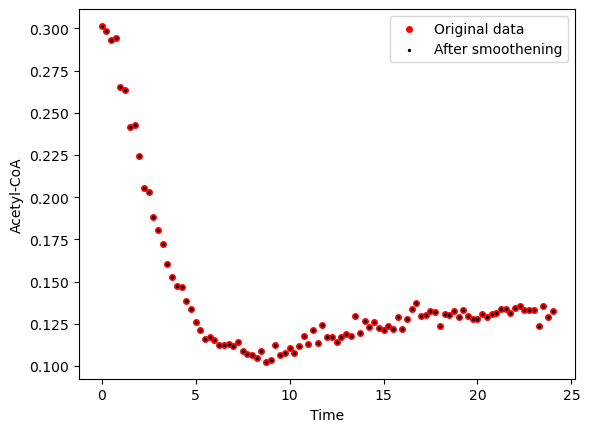

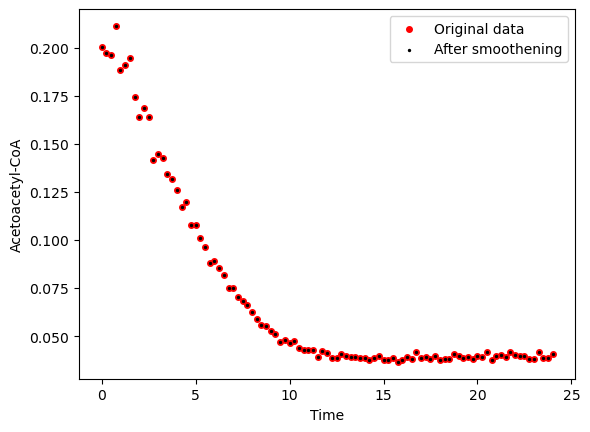

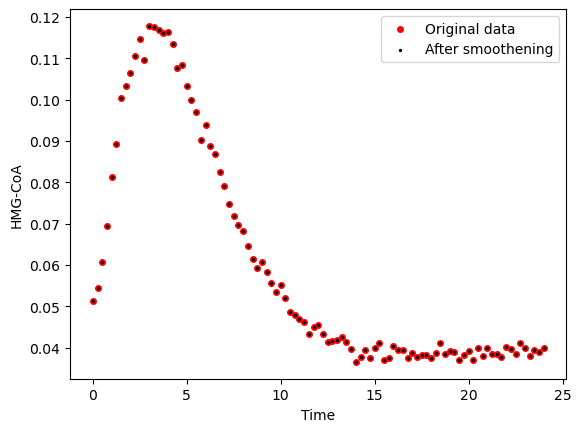

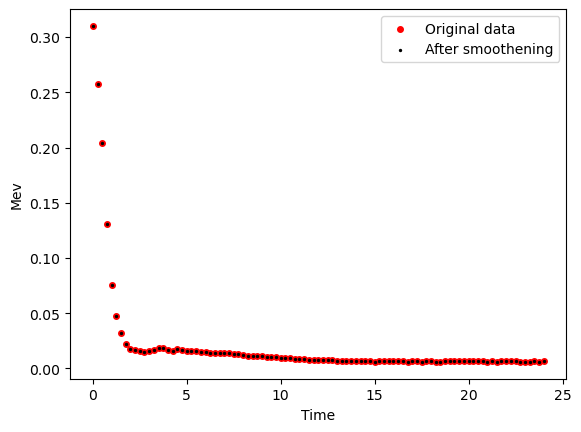

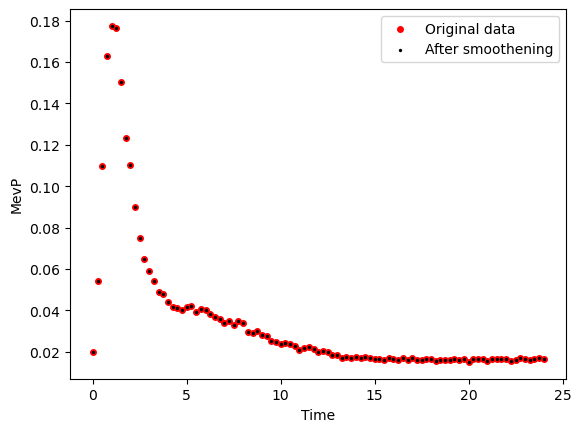

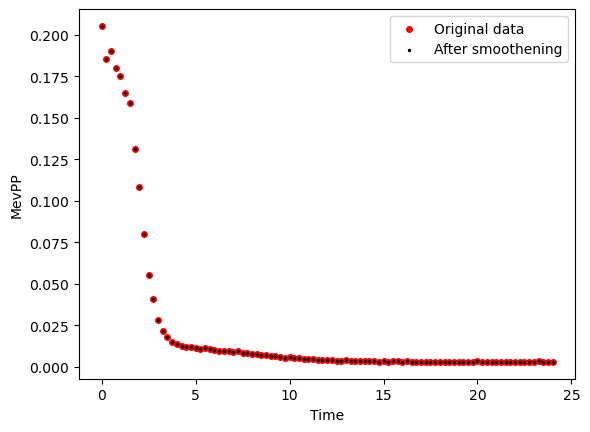

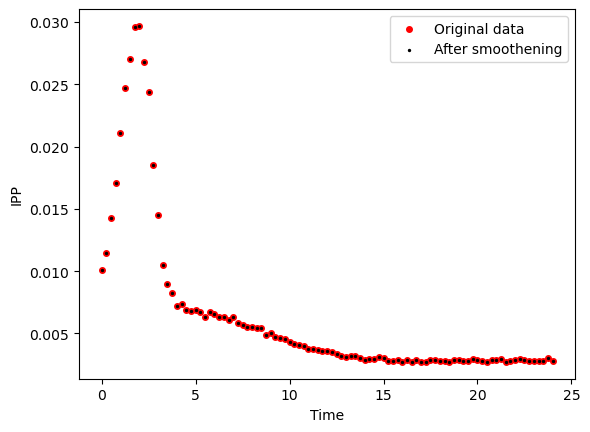

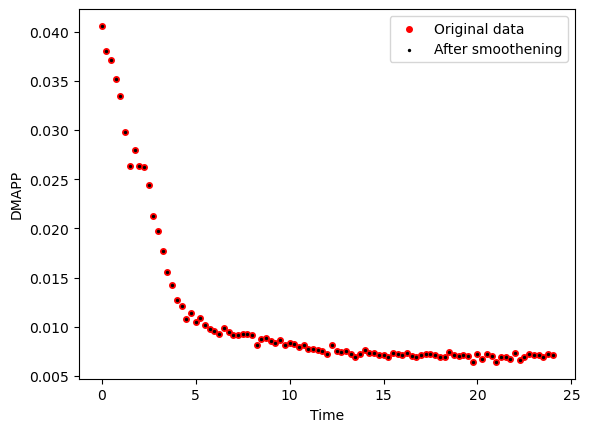

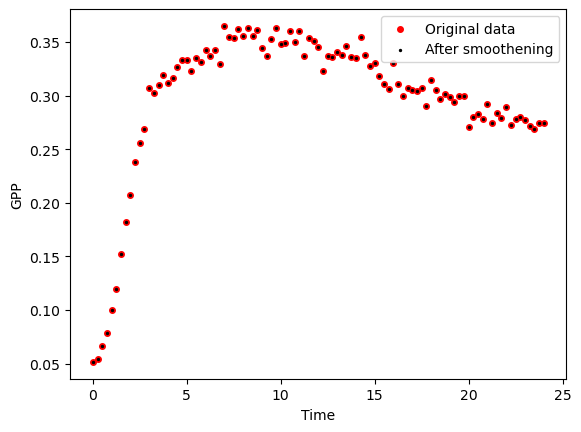

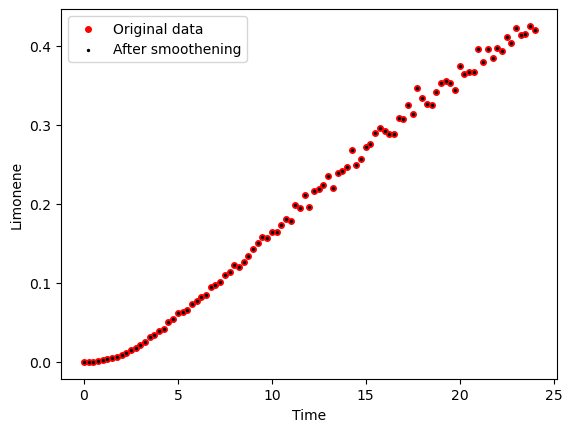

Strain Strain 2


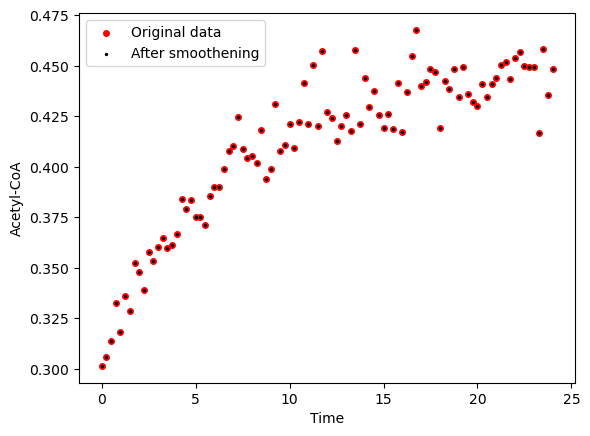

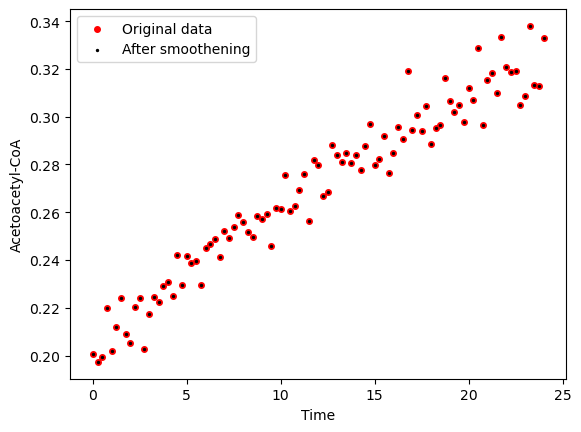

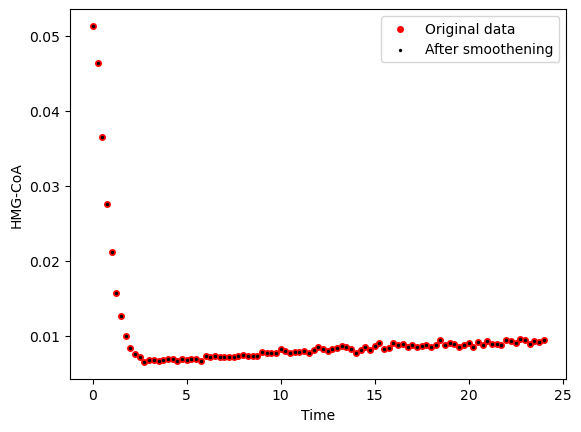

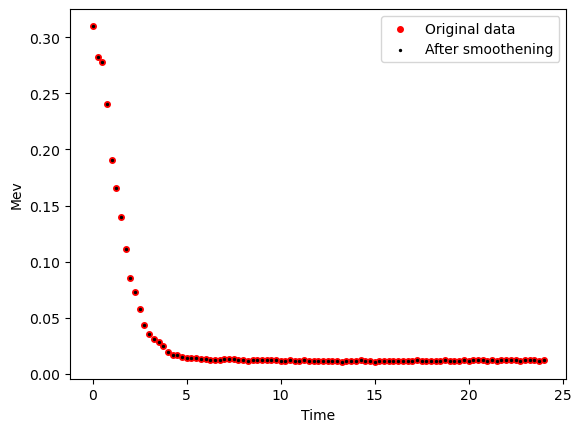

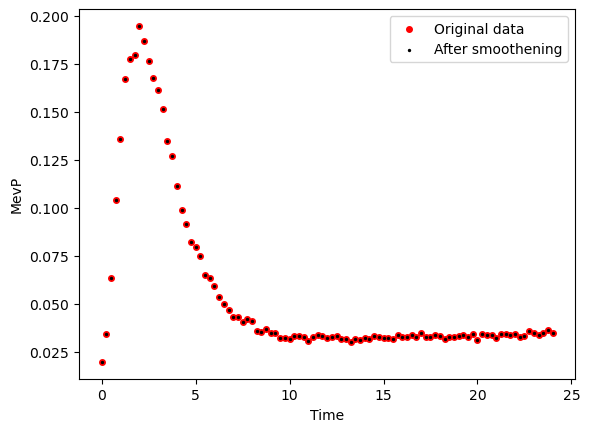

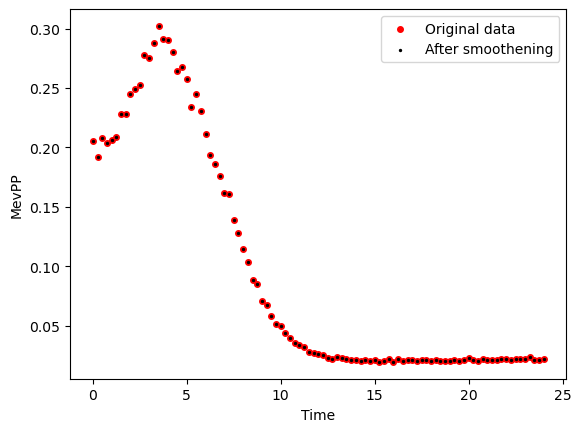

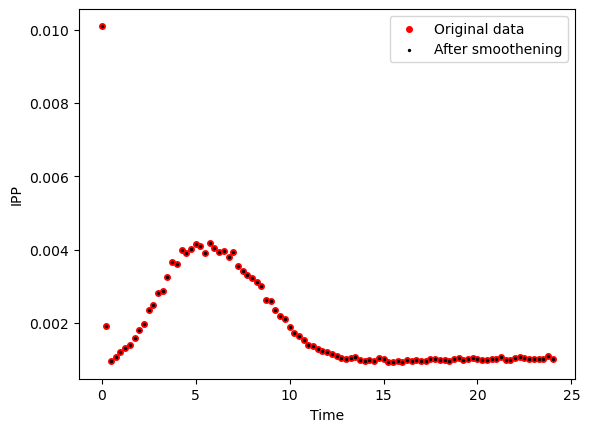

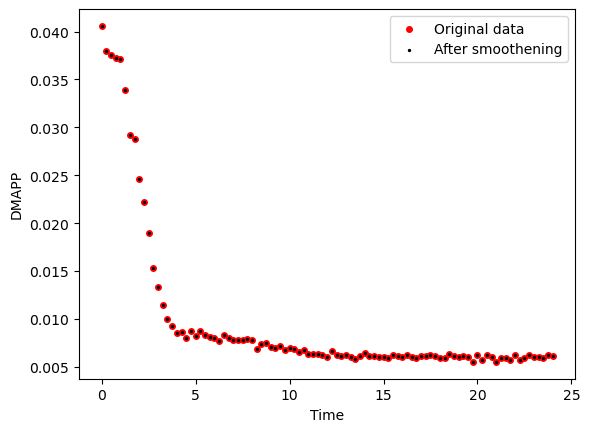

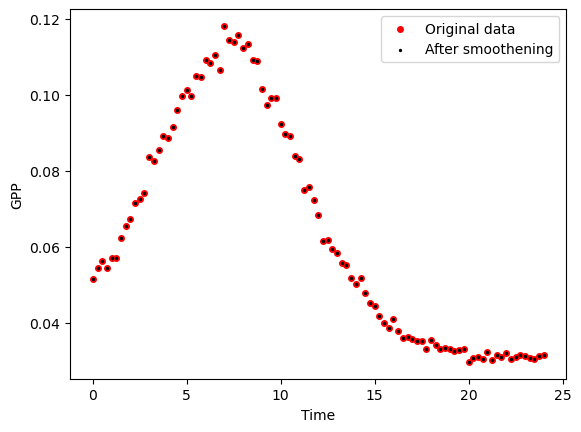

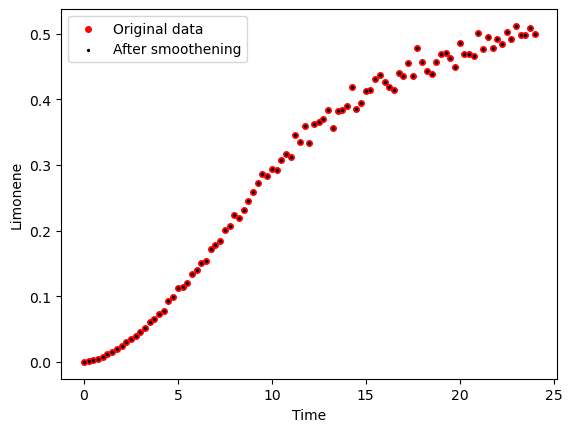

Strain Strain 3


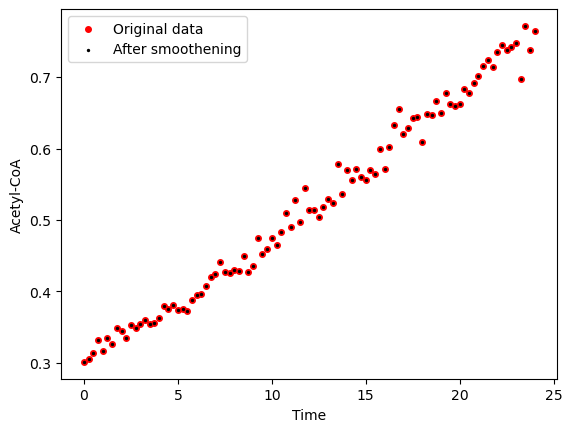

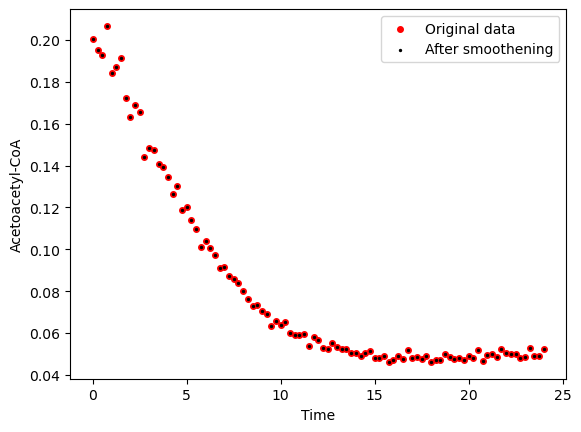

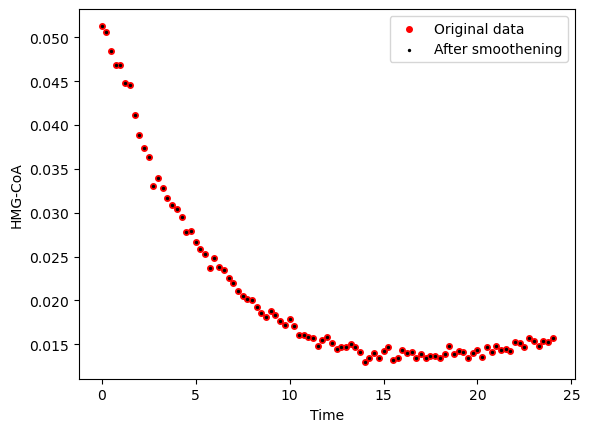

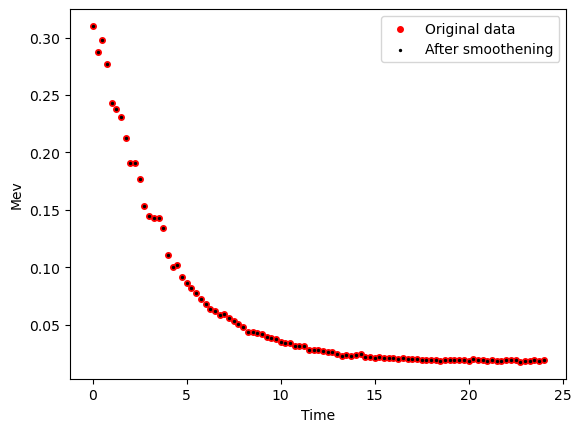

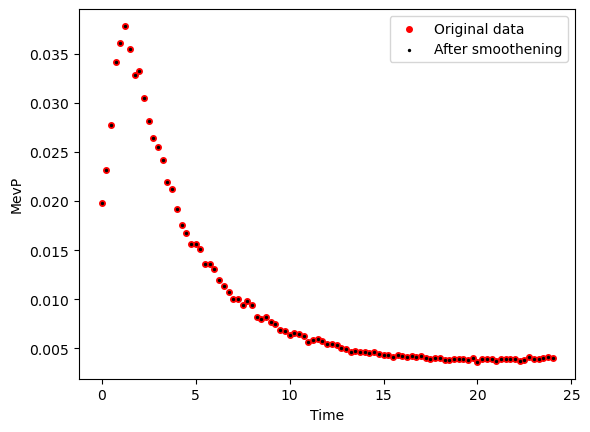

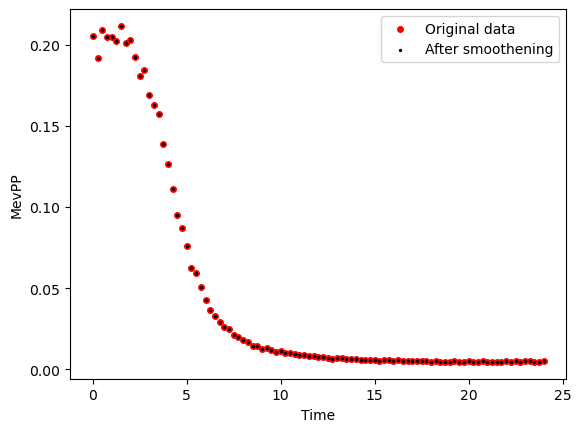

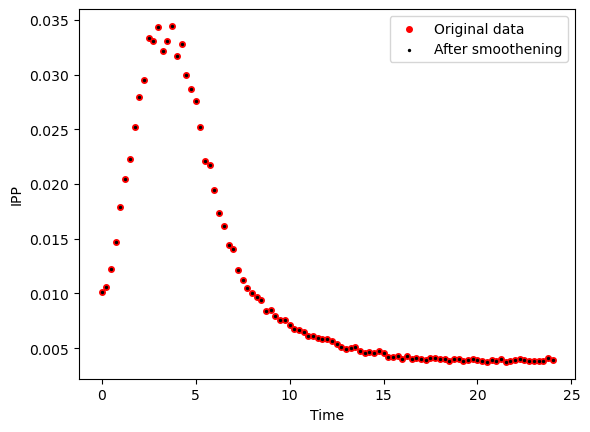

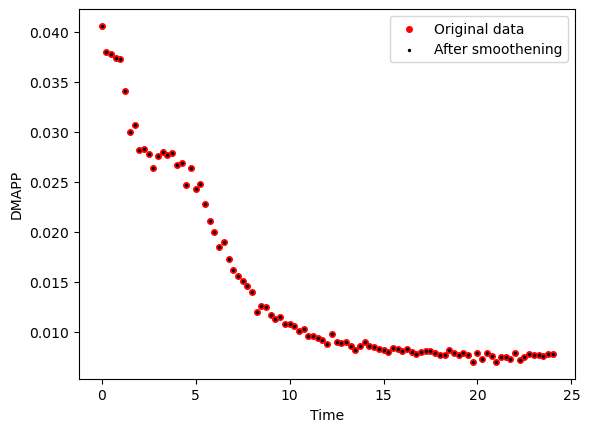

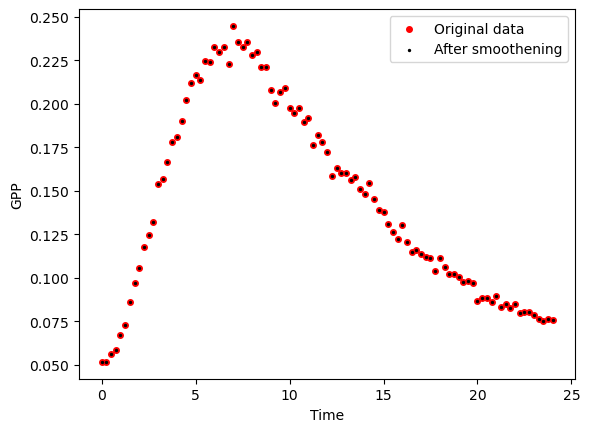

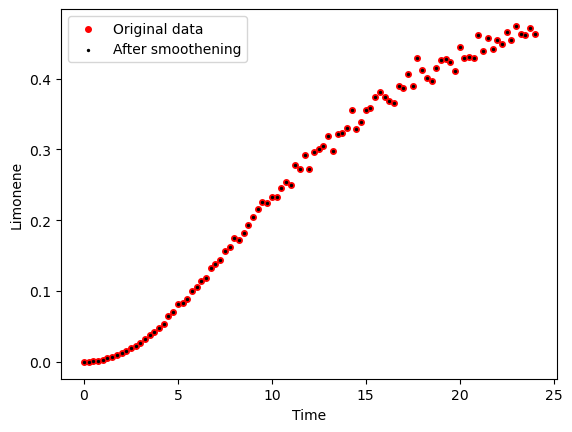

Strain WT


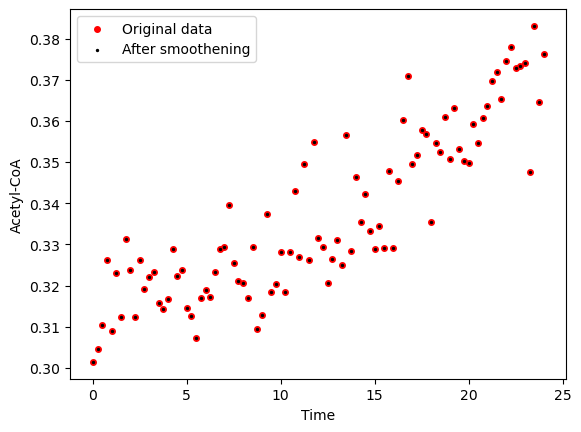

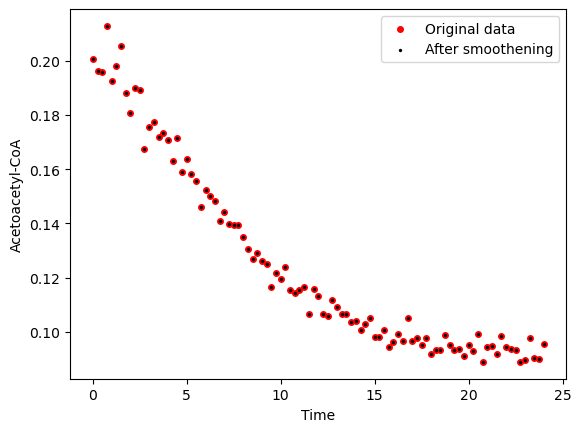

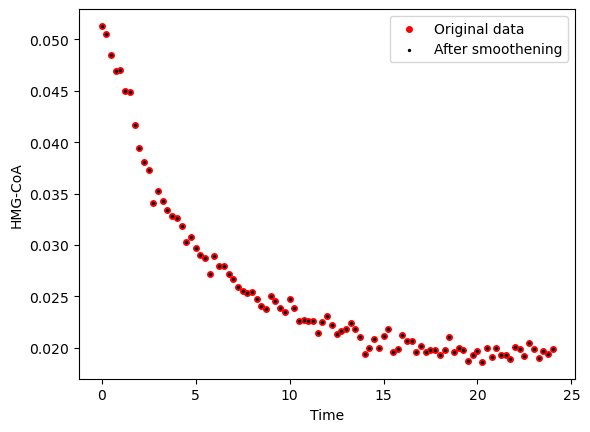

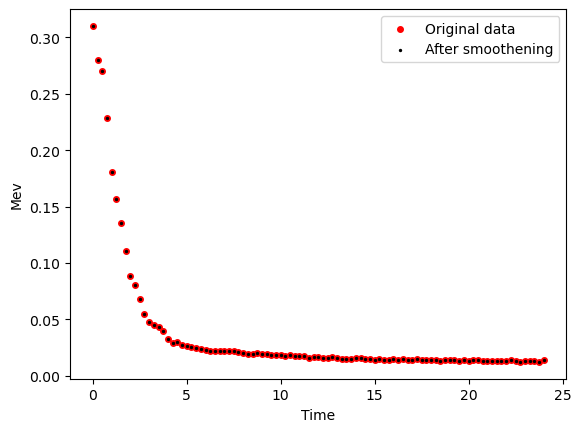

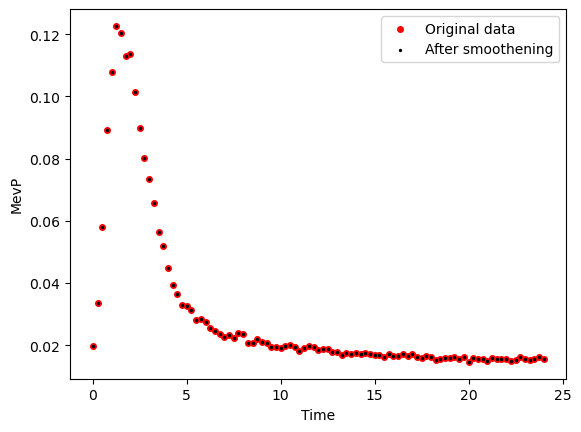

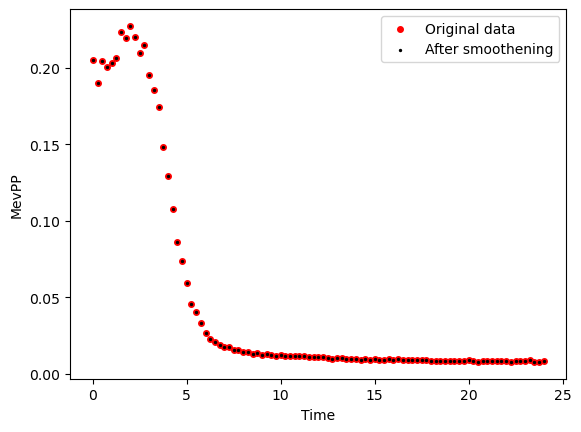

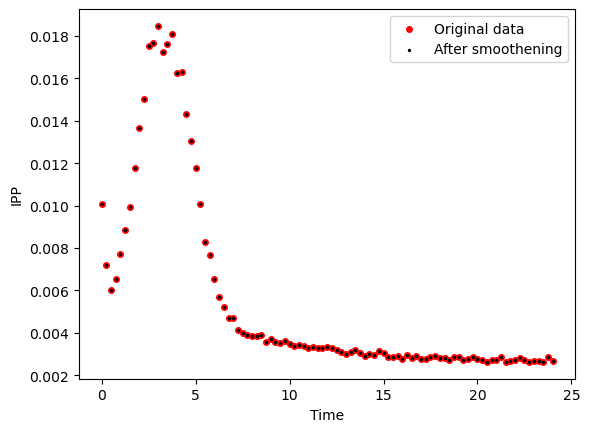

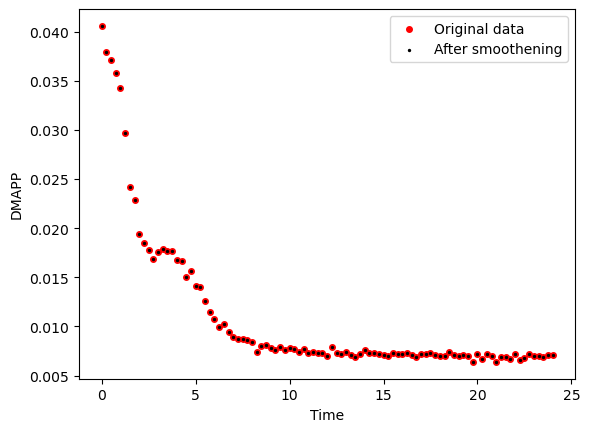

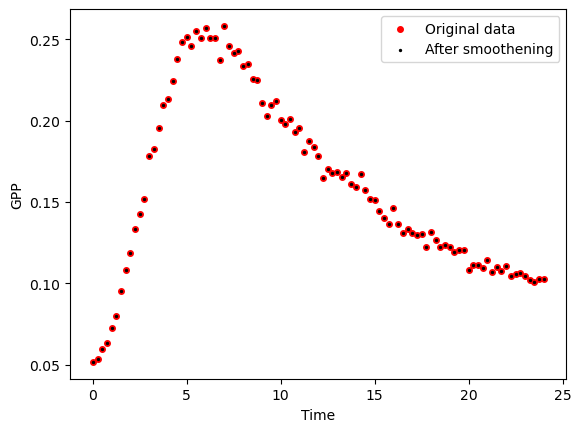

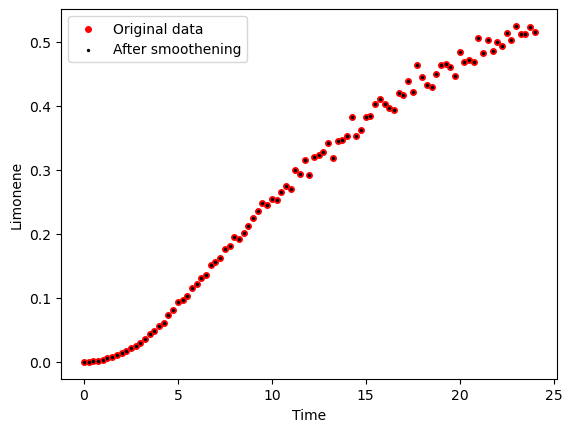

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


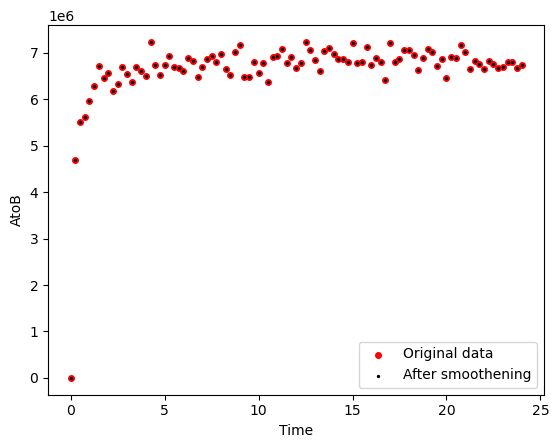

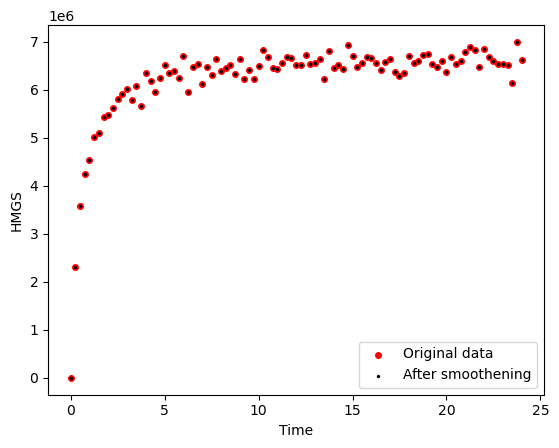

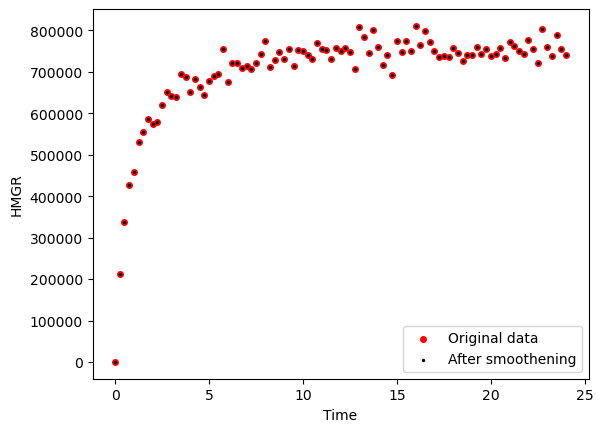

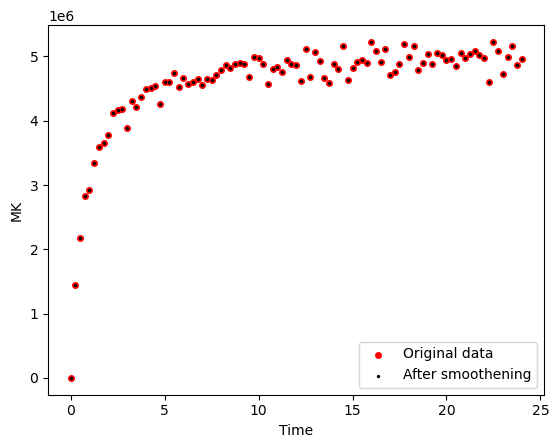

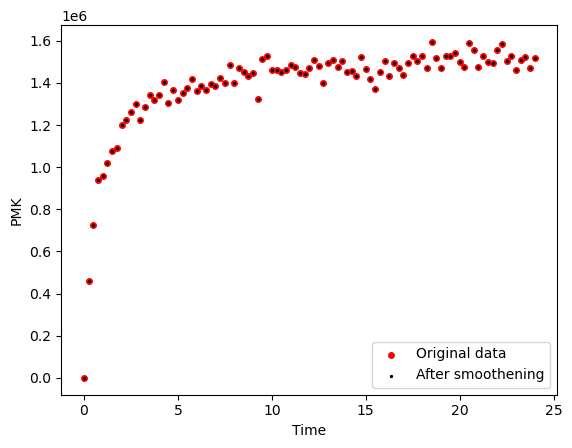

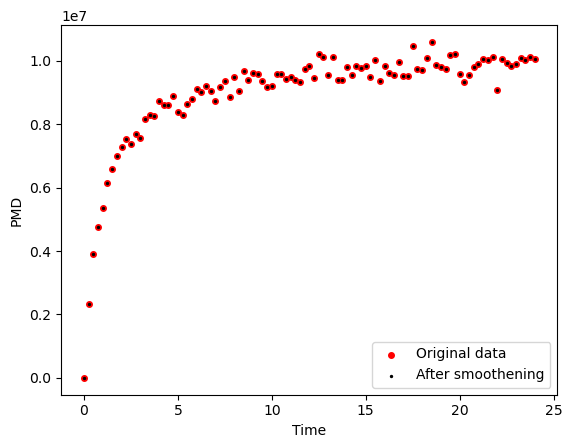

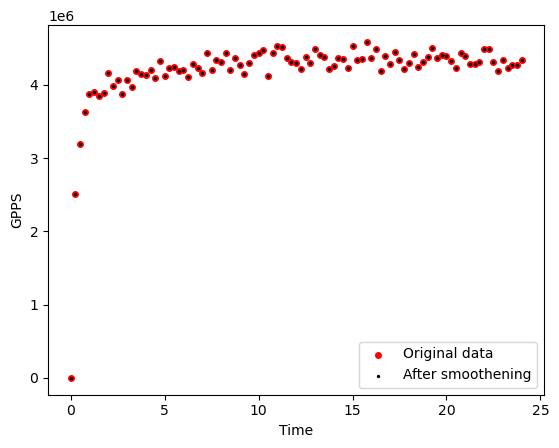

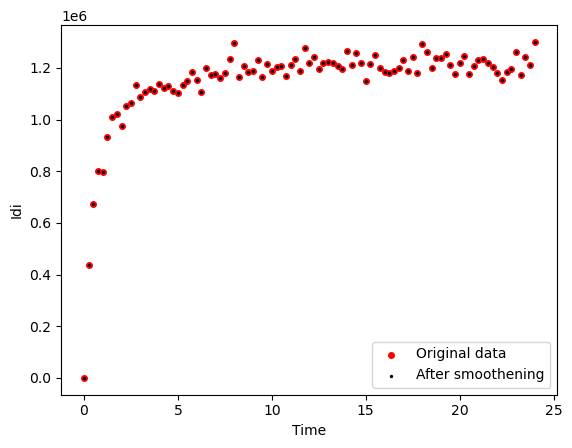

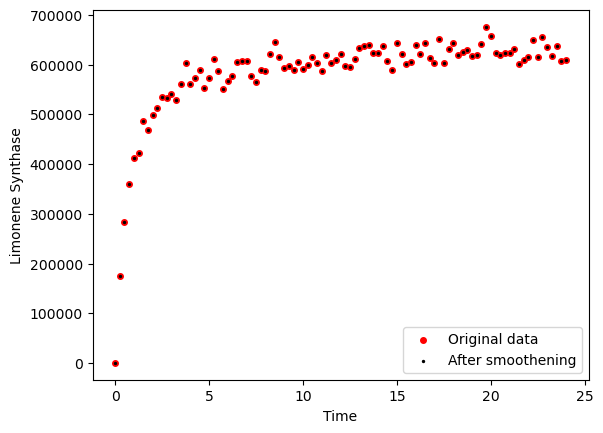

Strain Strain 2


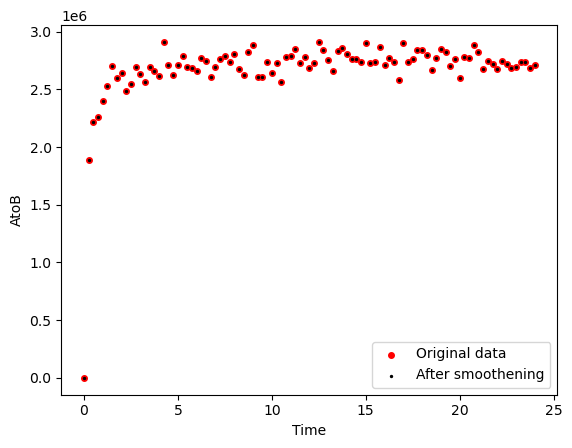

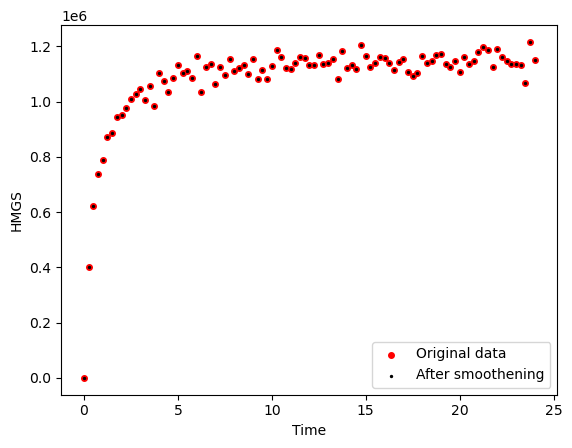

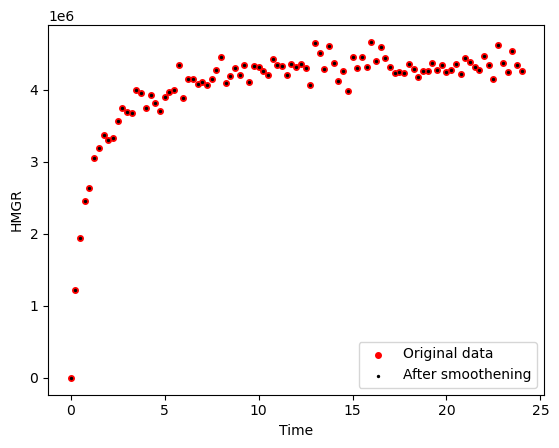

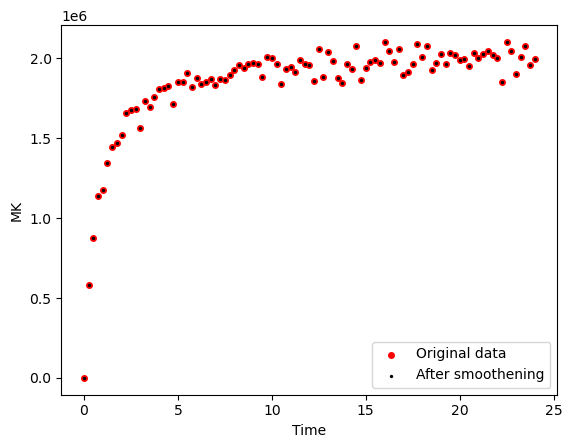

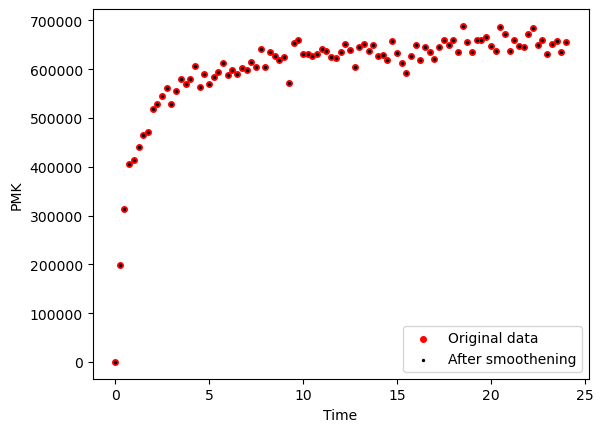

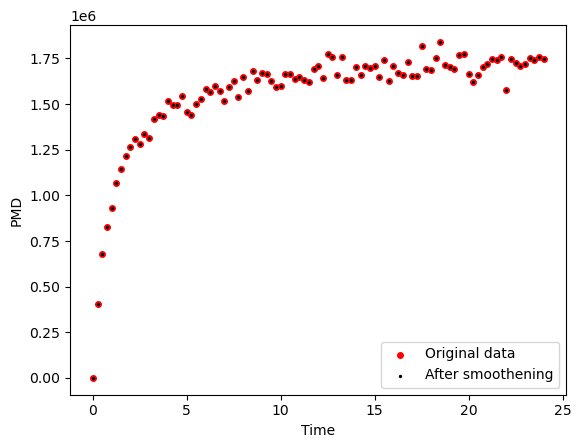

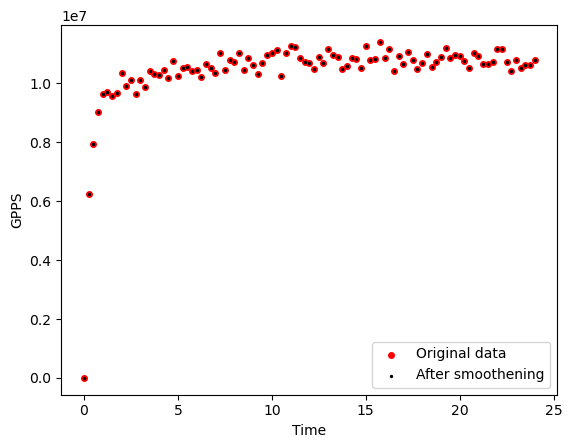

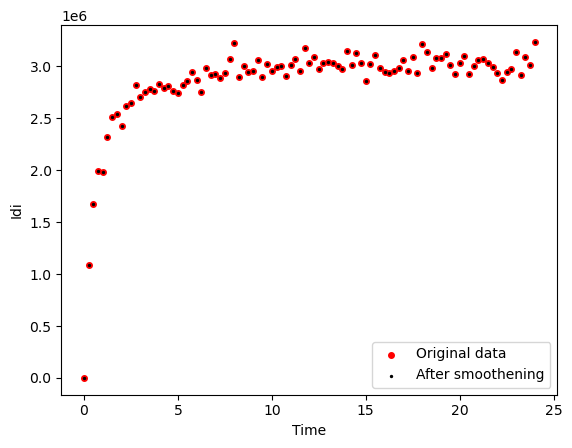

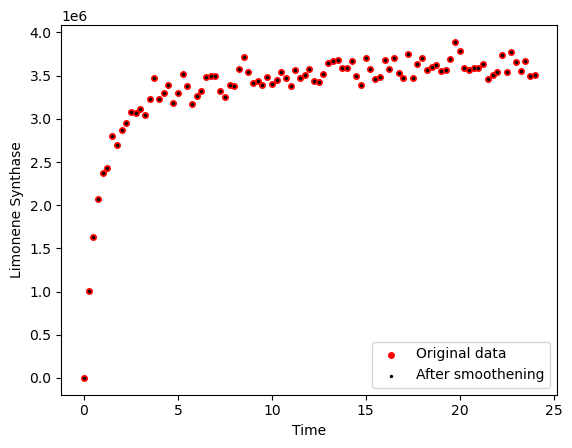

Strain Strain 3


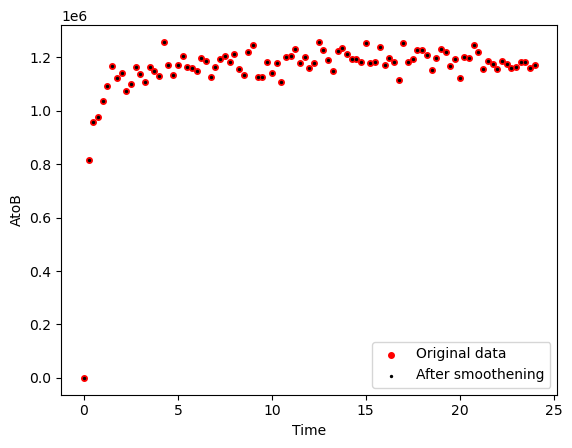

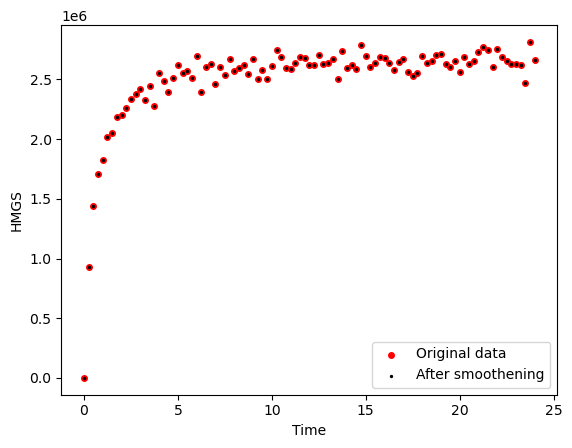

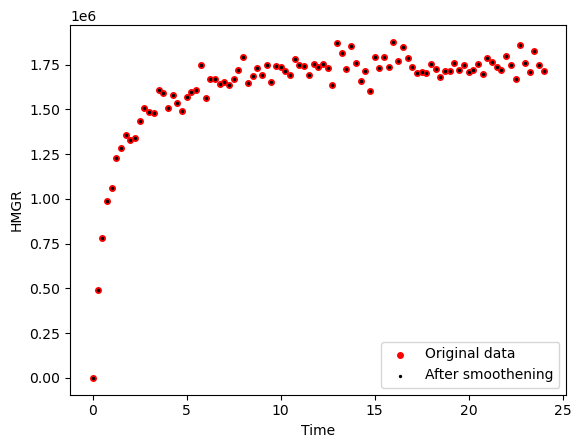

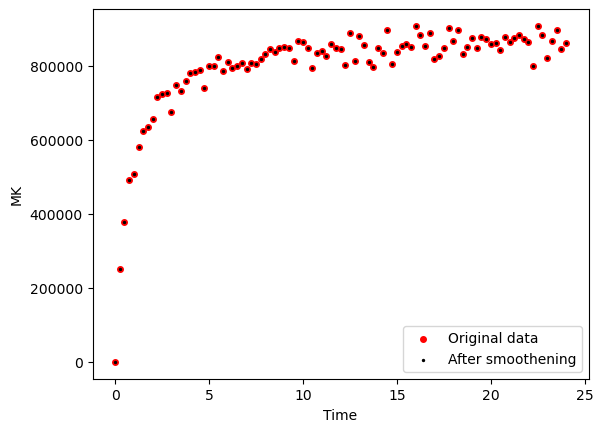

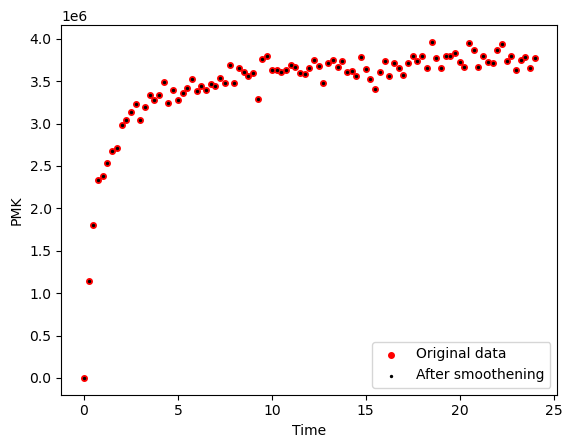

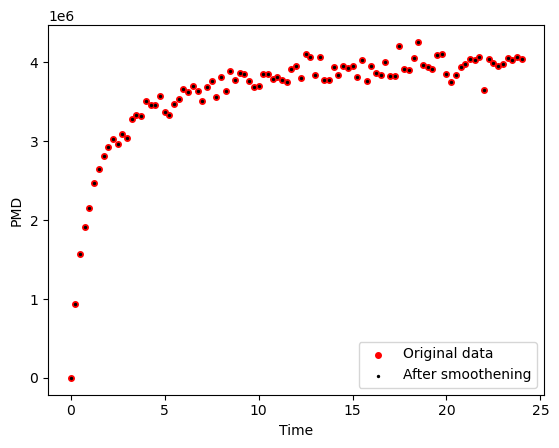

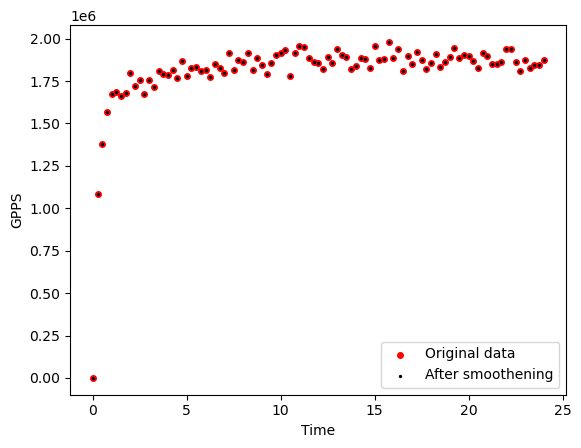

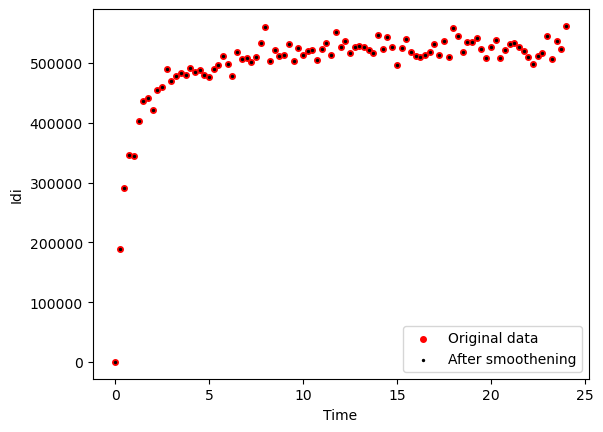

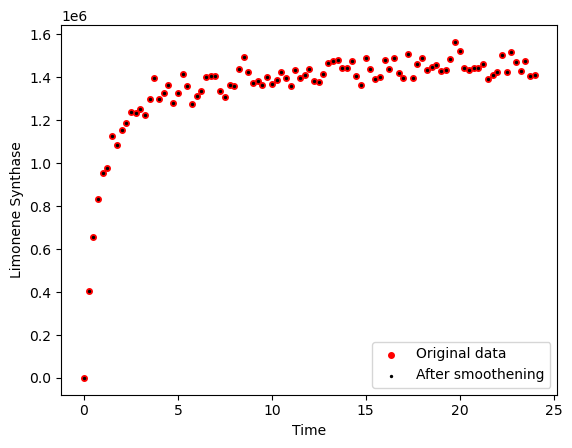

Strain WT


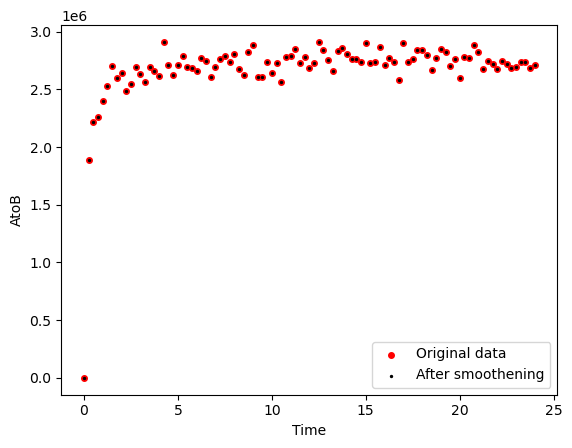

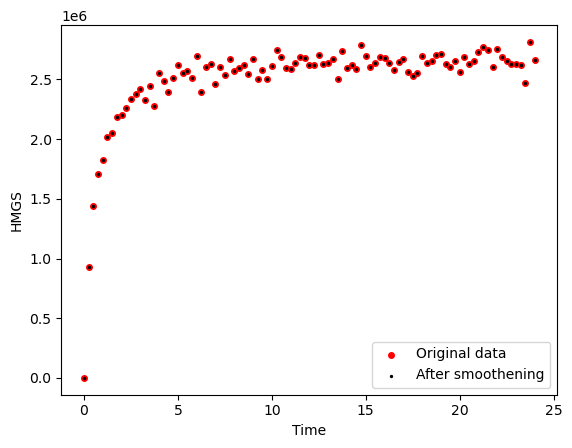

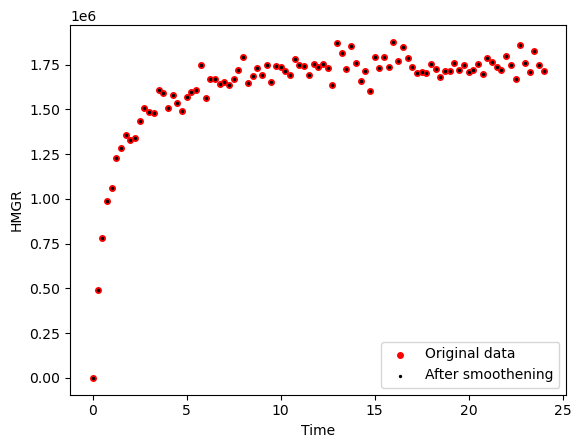

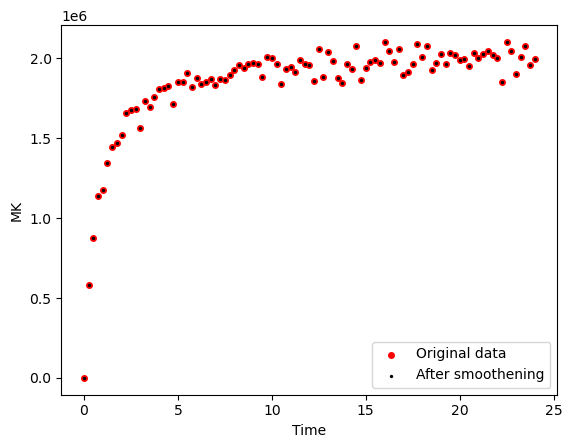

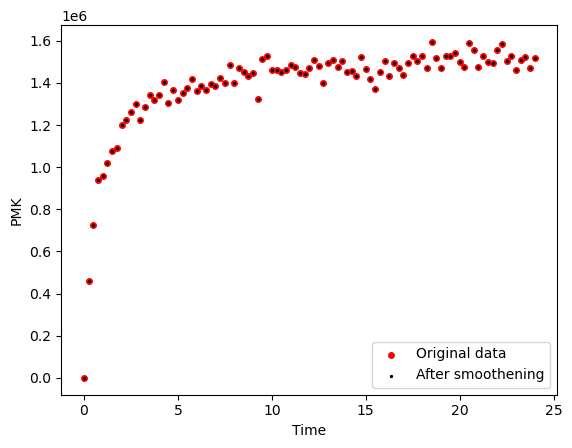

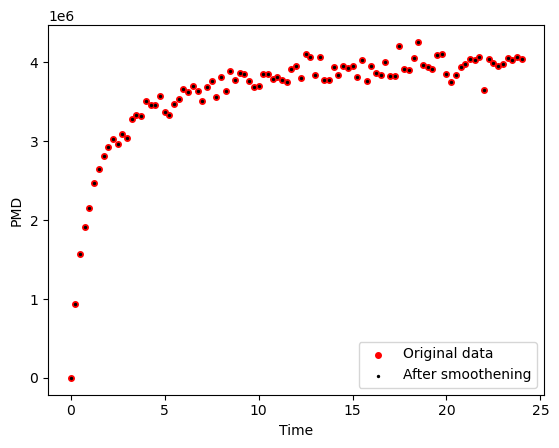

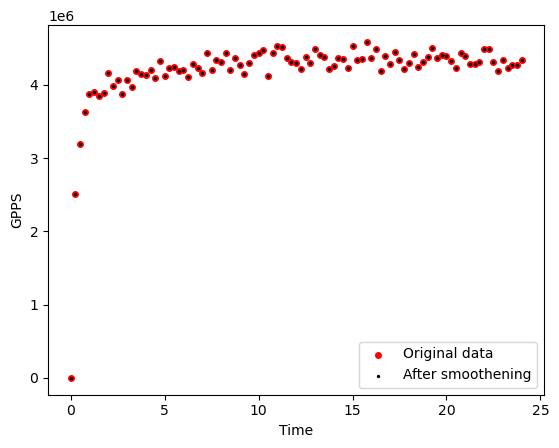

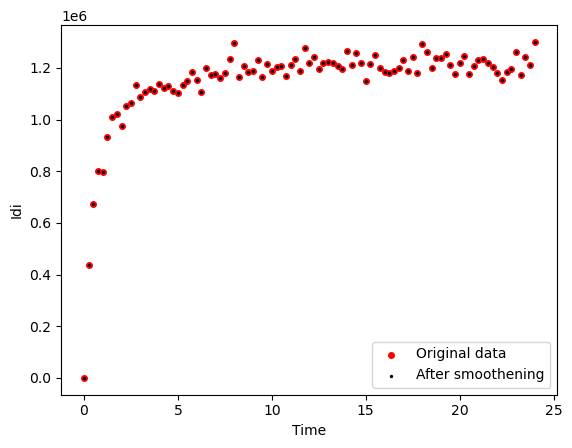

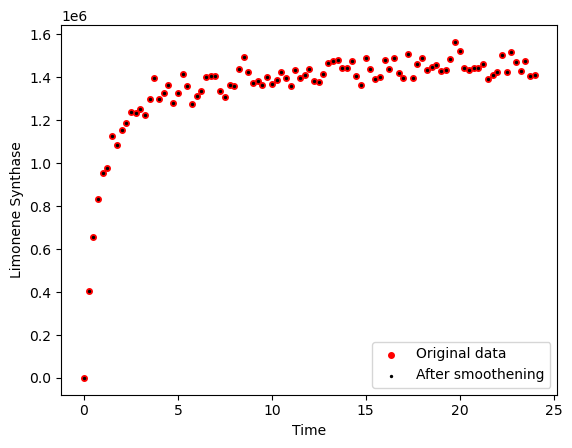

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative52

df_allSmooth=estimate_state_derivative52(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.301424        0.200524  0.051314  0.310136  0.019836   
         0.25    0.298643        0.196981  0.054571  0.257871  0.054087   
         0.50    0.293079        0.196226  0.060858  0.204159  0.109953   
         0.75    0.294486        0.211294  0.069487  0.131176  0.162939   
         1.00    0.265535        0.188490  0.081276  0.075154  0.177398   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.374192        0.089650  0.019896  0.012937  0.015625   
         23.25   0.347679        0.097818  0.018974  0.012972  0.015257   
         23.50   0.383099        0.090354  0.019643  0.013301  0.015644   
         23.75   0.364685        0.090033  0.019372  0.012560  0.016188   
         24.00   0.376166        0.095488  0.019913  0.013524  0.015543   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.205338  0.010099  0.040591  0.051599  0.000000  ...   
         0.25   0.185366  0.011454  0.038079  0.054414  0.000136  ...   
         0.50   0.190514  0.014237  0.037094  0.066244  0.000498  ...   
         0.75   0.179858  0.017065  0.035163  0.078271  0.001012  ...   
         1.00   0.175158  0.021085  0.033441  0.099951  0.001852  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.008177  0.002682  0.007011  0.104486  0.524887  ...   
         23.25  0.008644  0.002666  0.007002  0.102055  0.512296  ...   
         23.50  0.007730  0.002636  0.006887  0.100950  0.512485  ...   
         23.75  0.007649  0.002848  0.007141  0.102626  0.523739  ...   
         24.00  0.008073  0.002663  0.007080  0.102376  0.515208  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.021474        0.022038  0.007755 -0.208049  0.218122   
         0.25    -0.004450        0.009068  0.018845 -0.223356  0.193856   
         0.50    -0.030374       -0.003902  0.029936 -0.238663  0.169590   
         0.75    -0.039136       -0.007796  0.036022 -0.219741  0.124820   
         1.00    -0.053522       -0.009287  0.039657 -0.171363  0.037777   
...                    ...             ...       ...       ...       ...   
WT       23.00   -0.002126        0.001333 -0.000241  0.000426 -0.000045   
         23.25   -0.003419        0.001250 -0.000956  0.000415 -0.000084   
         23.50    0.008382        0.001556  0.000172  0.000305  0.000307   
         23.75    0.021041        0.002538  0.001308  0.000756  0.000081   
         24.00    0.033700        0.003519  0.002444  0.001208 -0.000146   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.043193  0.004892 -0.007609  0.004880  0.000051  
         0.25  -0.034770  0.007963 -0.007247  0.026552  0.000941  
         0.50  -0.026347  0.011033 -0.006886  0.048225  0.001832  
         0.75  -0.022400  0.013364 -0.008103  0.065405  0.002930  
         1.00  -0.031422  0.013328 -0.010759  0.084998  0.004036  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.000185 -0.000057 -0.000007 -0.005404  0.002370  
         23.25 -0.000505  0.000140 -0.000058 -0.004141  0.011594  
         23.50 -0.000482  0.000058  0.000111 -0.001460 -0.003167  
         23.75 -0.000055  0.000003  0.000263  0.002622  0.007797  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

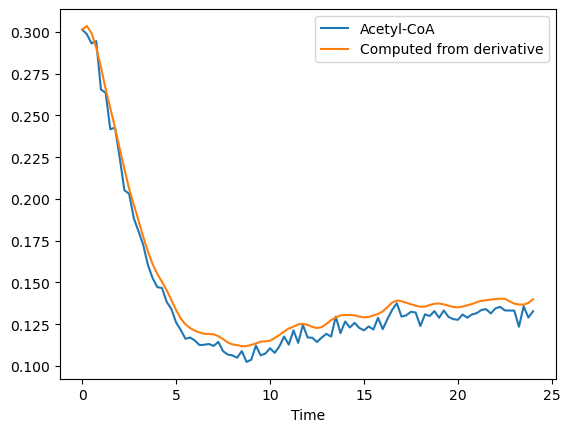

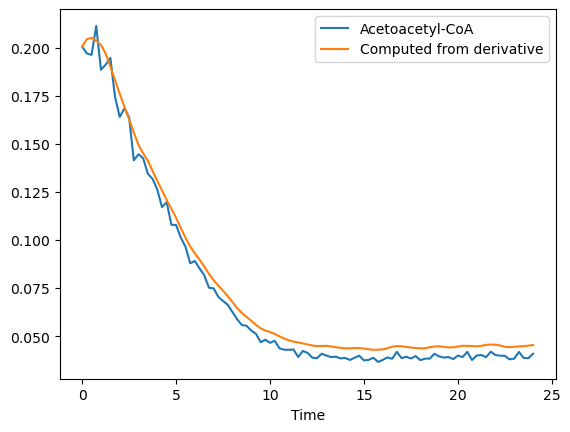

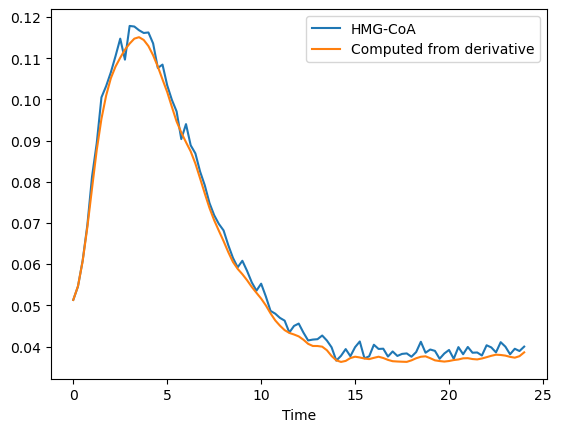

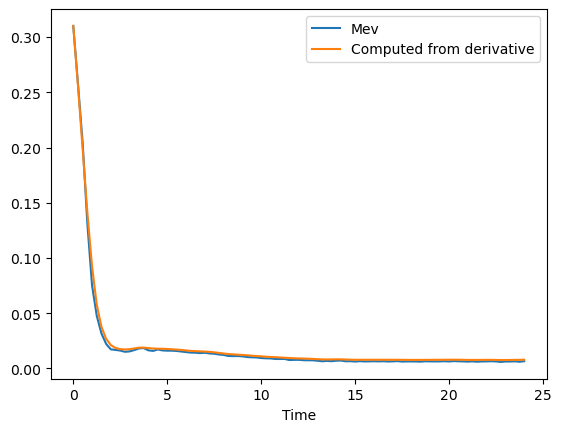

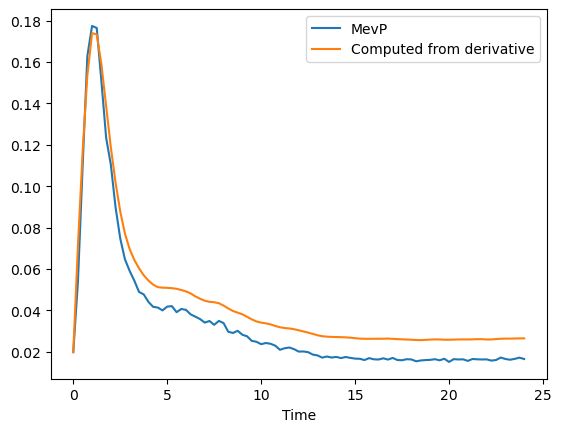

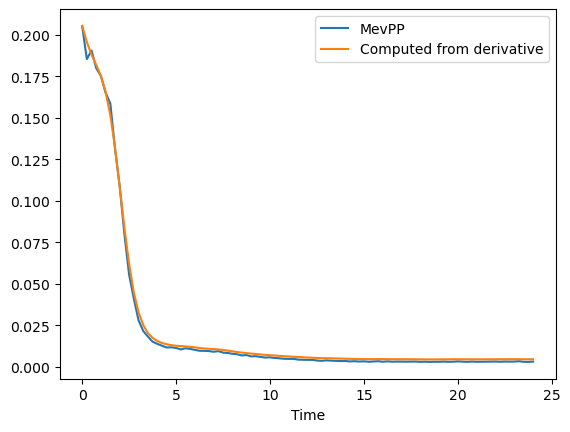

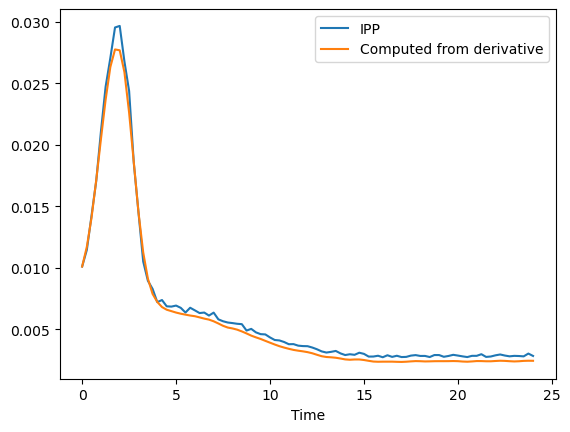

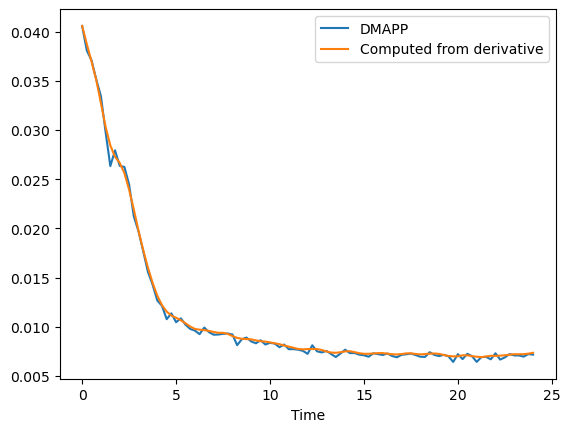

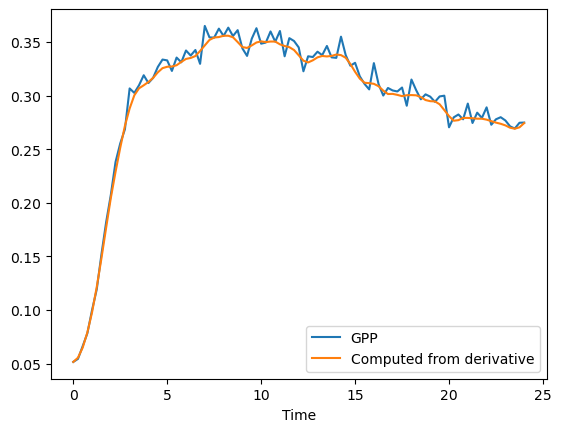

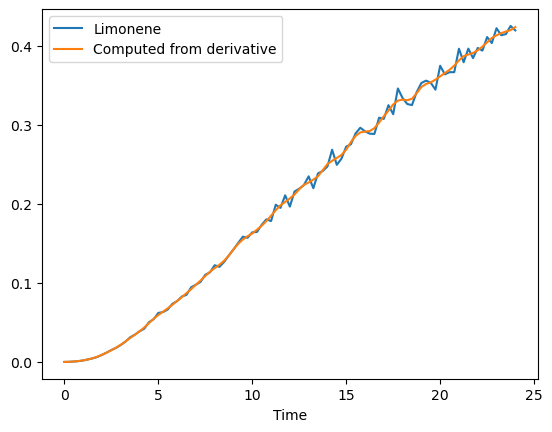

'Time profile from derivative vs. actual profile for Strain 2'

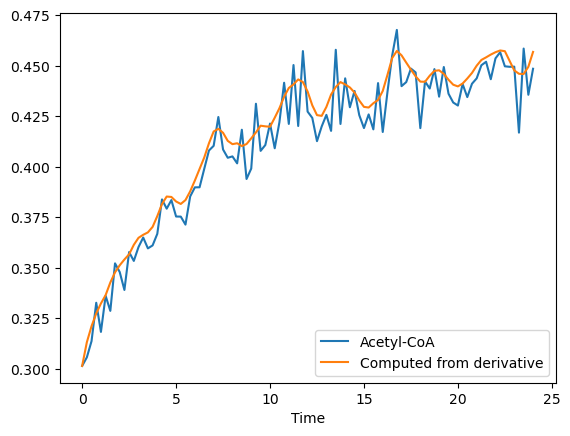

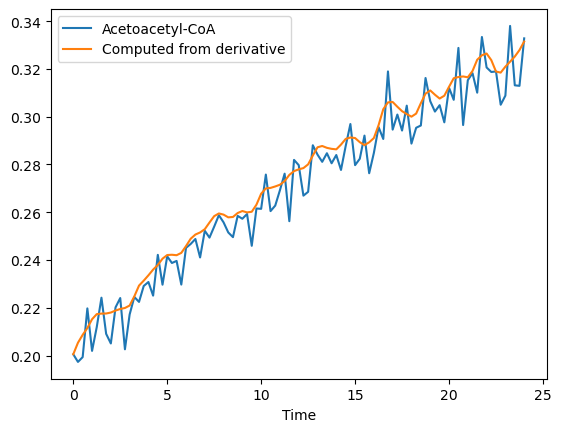

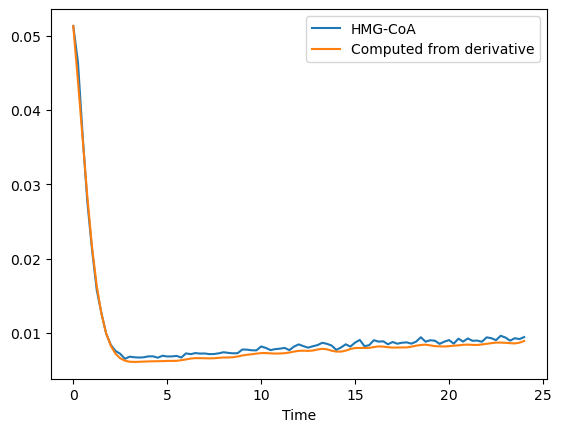

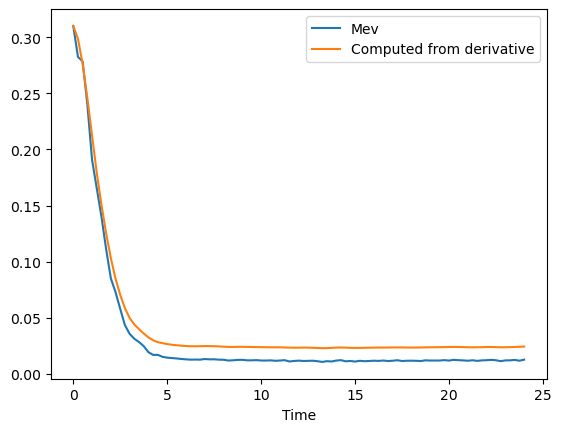

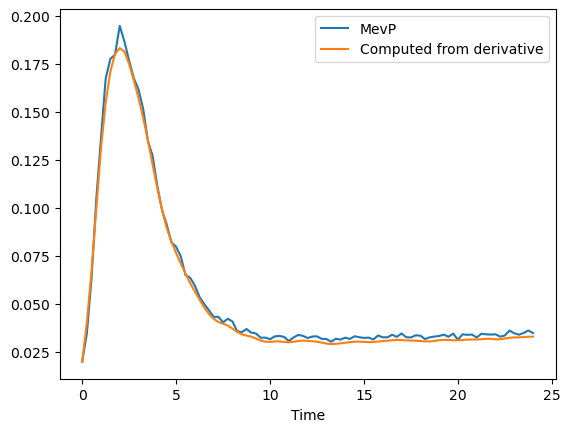

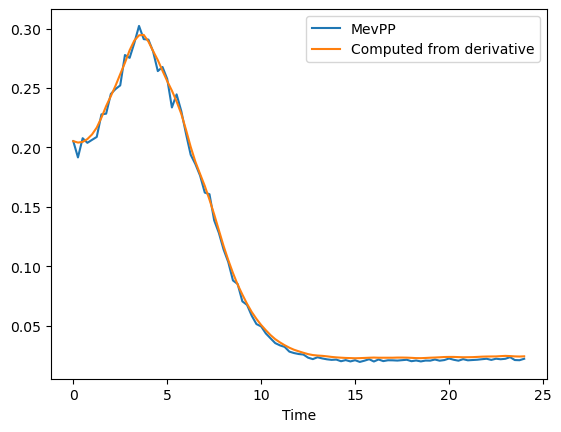

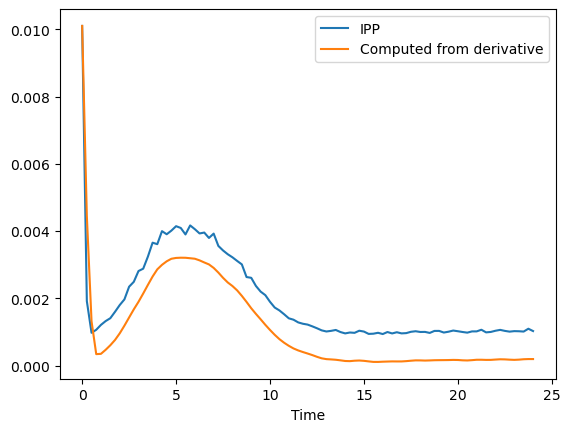

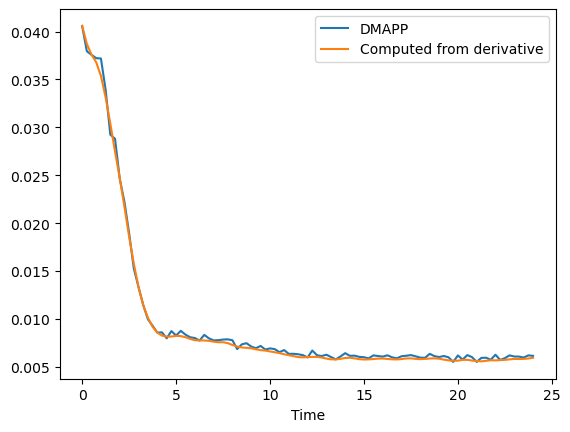

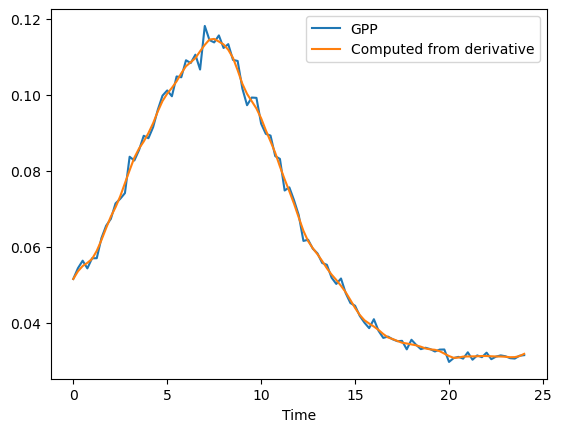

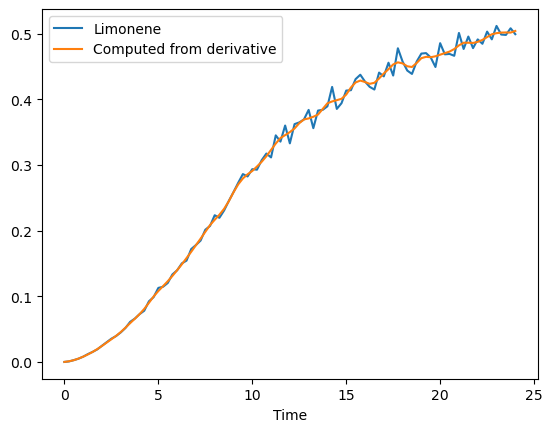

'Time profile from derivative vs. actual profile for Strain 3'

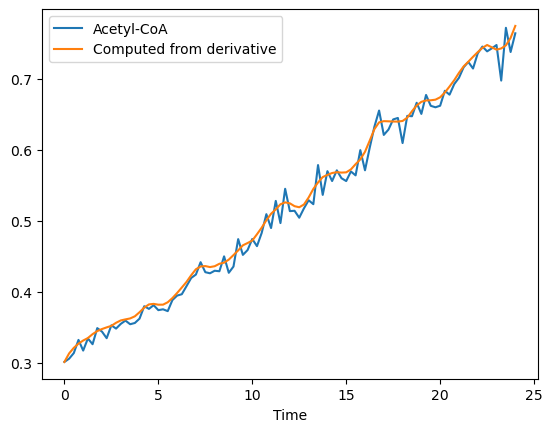

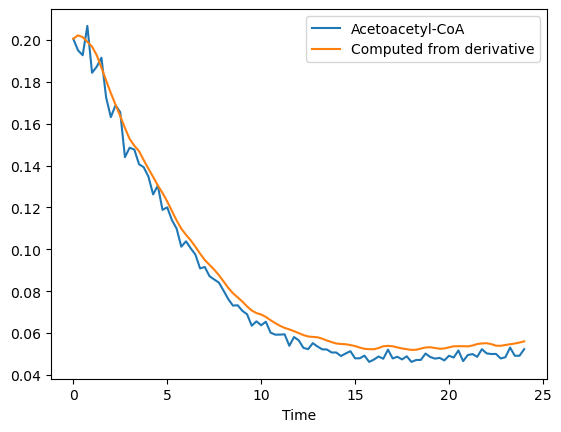

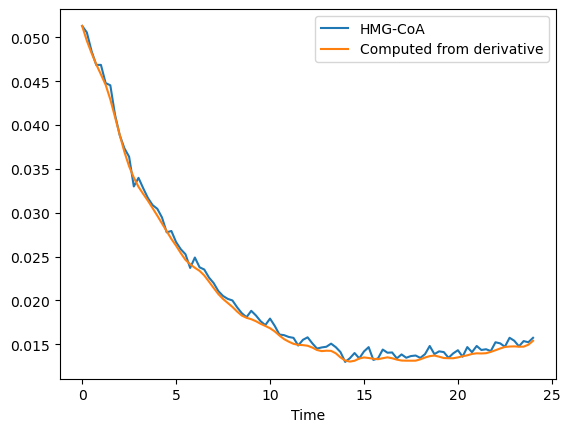

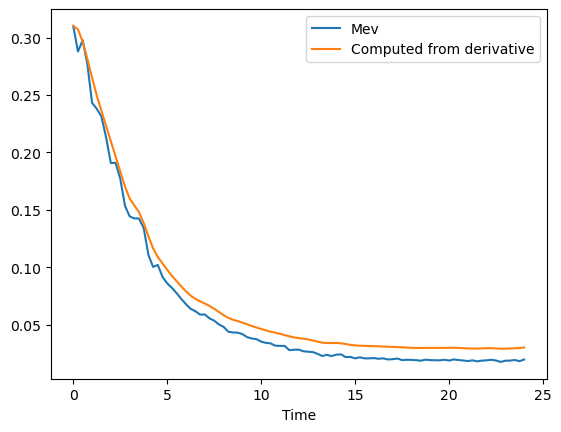

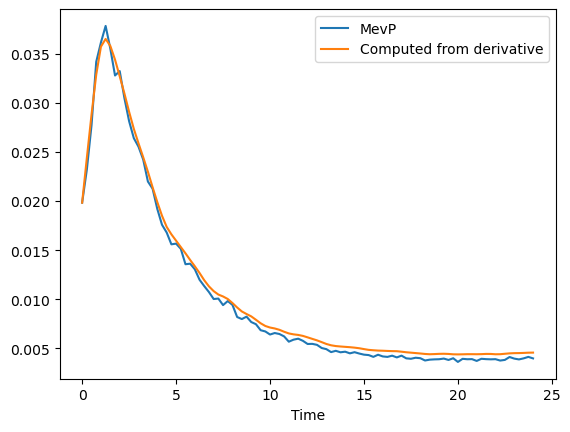

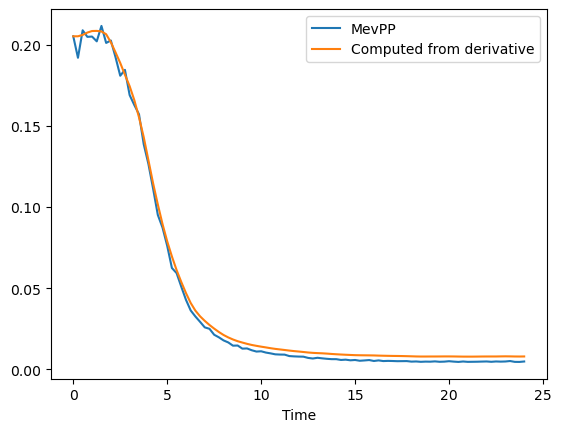

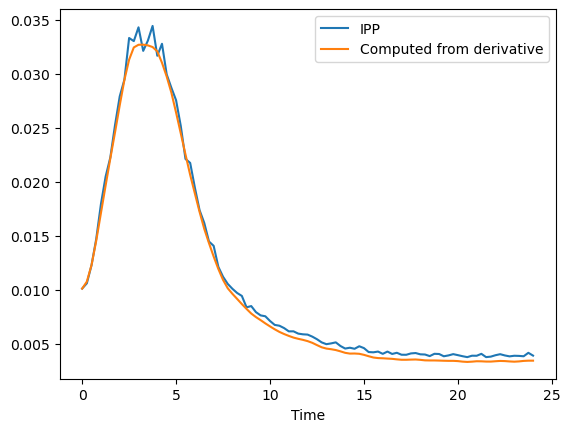

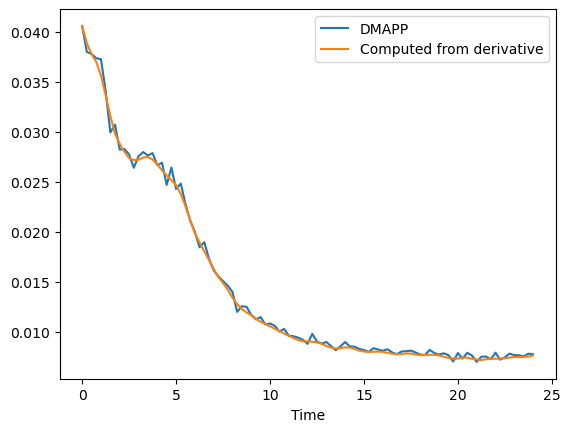

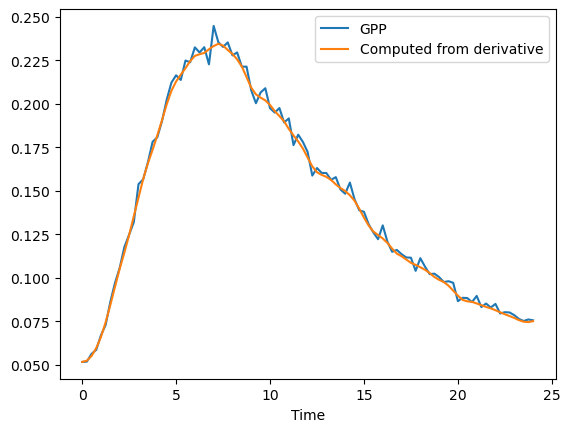

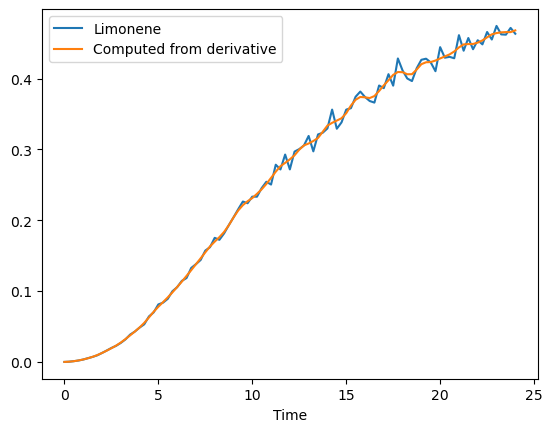

'Time profile from derivative vs. actual profile for WT'

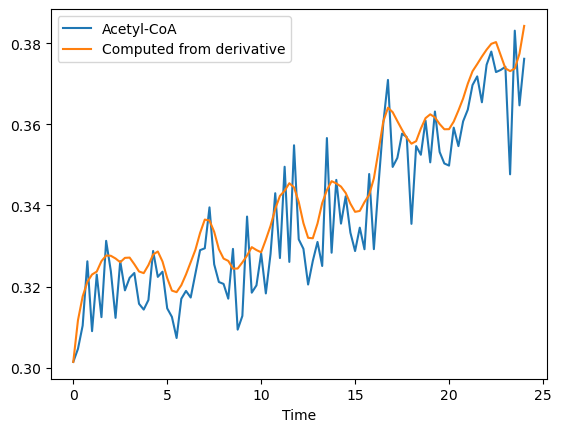

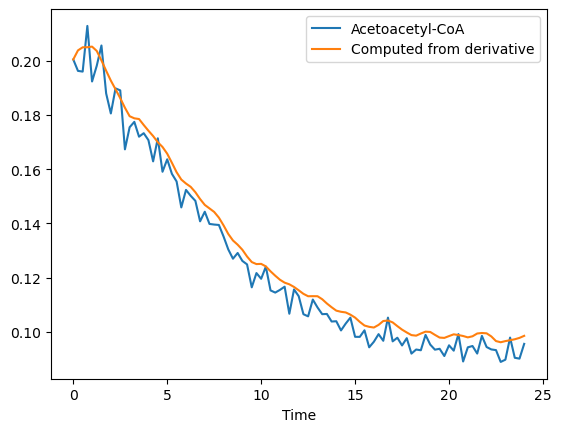

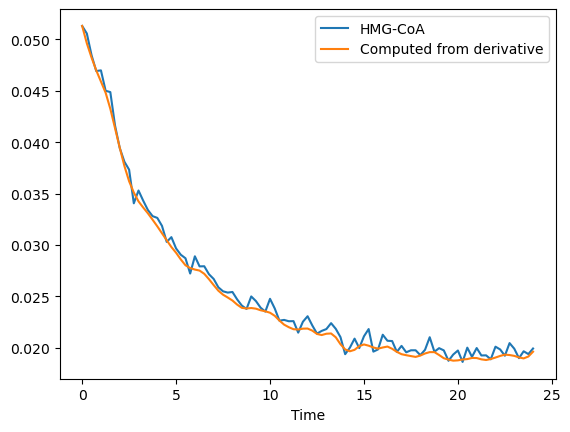

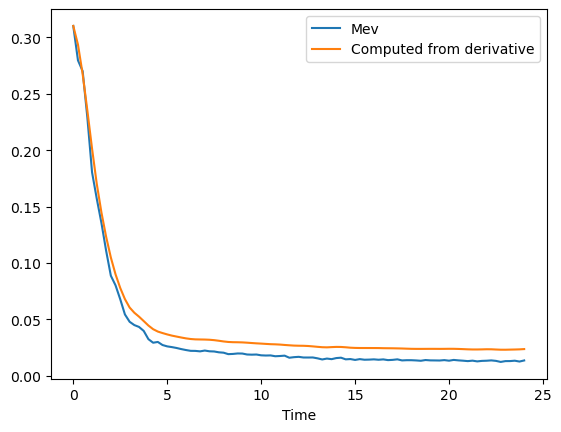

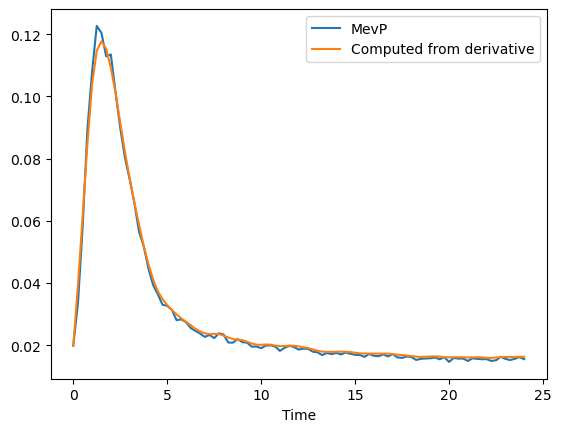

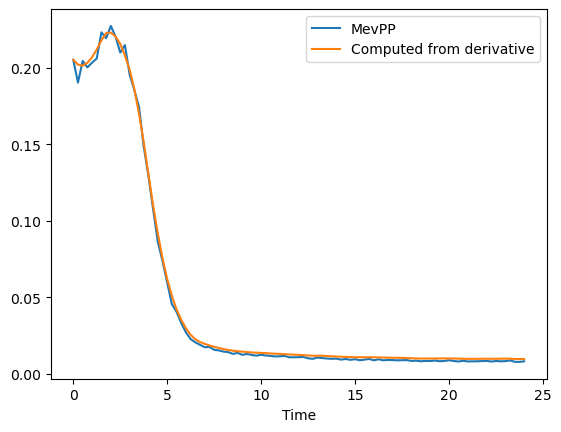

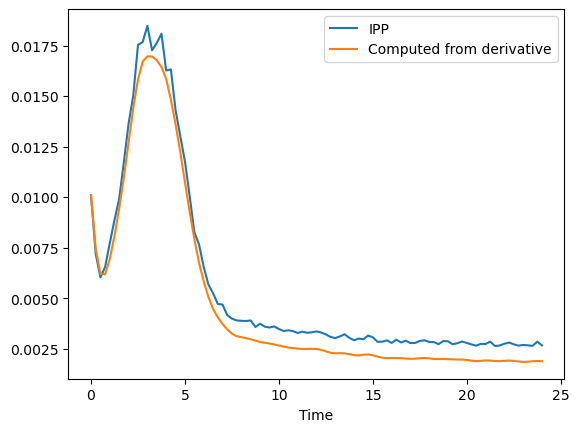

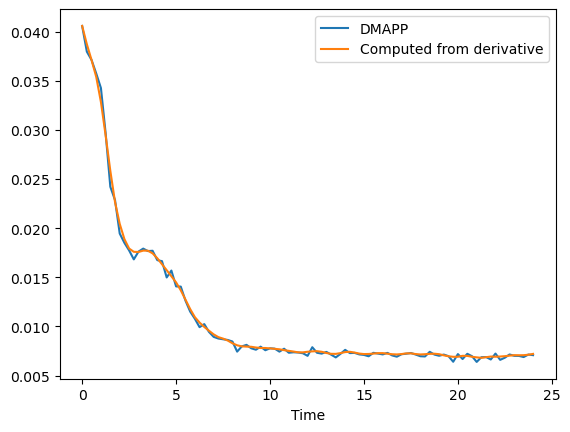

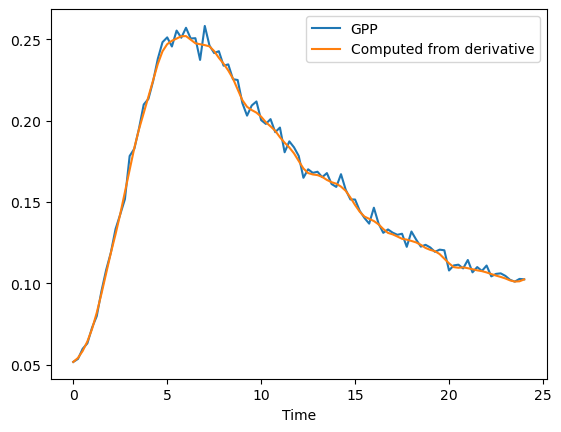

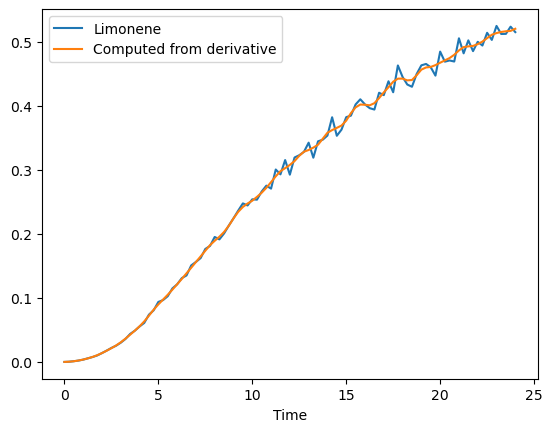

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.975196e+01  3.983424e+01  3.794074e+01  5.956960e+01   
         0.25   4.701158e+06  2.310954e+06  2.119978e+05  1.441237e+06   
         0.50   5.502124e+06  3.575914e+06  3.366702e+05  2.170702e+06   
         0.75   5.623466e+06  4.247346e+06  4.275388e+05  2.825850e+06   
         1.00   5.955090e+06  4.539072e+06  4.585594e+05  2.920864e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.689569e+06  2.630148e+06  1.757743e+06  1.904057e+06   
         23.25  2.733544e+06  2.618057e+06  1.711420e+06  2.009699e+06   
         23.50  2.734135e+06  2.467534e+06  1.824467e+06  2.078923e+06   
         23.75  2.680720e+06  2.813879e+06  1.748044e+06  1.955688e+06   
         24.00  2.711076e+06  2.661960e+06  1.713837e+06  1.994255e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.638142e+01  5.593531e+01  5.601897e+01  1.896372e+01   
         0.25   4.608750e+05  2.322661e+06  2.503681e+06  4.352779e+05   
         0.50   7.231798e+05  3.919590e+06  3.198510e+06  6.714010e+05   
         0.75   9.394797e+05  4.754849e+06  3.623287e+06  8.029395e+05   
         1.00   9.578282e+05  5.359746e+06  3.869362e+06  7.990530e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.460535e+06  3.983613e+06  4.334639e+06  1.261007e+06   
         23.25  1.508445e+06  4.058411e+06  4.235609e+06  1.171376e+06   
         23.50  1.523110e+06  4.035833e+06  4.267526e+06  1.241947e+06   
         23.75  1.469273e+06  4.064084e+06  4.274867e+06  1.211990e+06   
         24.00  1.520002e+06  4.038968e+06  4.343808e+06  1.300751e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.131118e+01   0.301424        0.200524  0.051314   
         0.25       1.742035e+05   0.298643        0.196981  0.054571   
         0.50       2.830033e+05   0.293079        0.196226  0.060858   
         0.75       3.603272e+05   0.294486        0.211294  0.069487   
         1.00       4.121310e+05   0.265535        0.188490  0.081276   
...                          ...        ...             ...       ...   
WT       23.00      1.472488e+06   0.374192        0.089650  0.019896   
         23.25      1.428807e+06   0.347679        0.097818  0.018974   
         23.50      1.473668e+06   0.383099        0.090354  0.019643   
         23.75      1.408105e+06   0.364685        0.090033  0.019372   
         24.00      1.412659e+06   0.376166        0.095488  0.019913   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.310136  0.019836  0.205338  0.010099  0.040591  0.051599   
         0.25   0.257871  0.054087  0.185366  0.011454  0.038079  0.054414   
         0.50   0.204159  0.109953  0.190514  0.014237  0.037094  0.066244   
         0.75   0.131176  0.162939  0.179858  0.017065  0.035163  0.078271   
         1.00   0.075154  0.177398  0.175158  0.021085  0.033441  0.099951   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.012937  0.015625  0.008177  0.002682  0.007011  0.104486   
         23.25  0.012972  0.015257  0.008644  0.002666  0.007002  0.102055   
         23.50  0.013301  0.015644  0.007730  0.002636  0.006887 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.021474        0.022038  0.007755 -0.208049  0.218122   
         0.25    -0.004450        0.009068  0.018845 -0.223356  0.193856   
         0.50    -0.030374       -0.003902  0.029936 -0.238663  0.169590   
         0.75    -0.039136       -0.007796  0.036022 -0.219741  0.124820   
         1.00    -0.053522       -0.009287  0.039657 -0.171363  0.037777   
...                    ...             ...       ...       ...       ...   
WT       23.00   -0.002126        0.001333 -0.000241  0.000426 -0.000045   
         23.25   -0.003419        0.001250 -0.000956  0.000415 -0.000084   
         23.50    0.008382        0.001556  0.000172  0.000305  0.000307   
         23.75    0.021041        0.002538  0.001308  0.000756  0.000081   
         24.00    0.033700        0.003519  0.002444  0.001208 -0.000146   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.043193  0.004892 -0.007609  0.004880  0.000051  
         0.25  -0.034770  0.007963 -0.007247  0.026552  0.000941  
         0.50  -0.026347  0.011033 -0.006886  0.048225  0.001832  
         0.75  -0.022400  0.013364 -0.008103  0.065405  0.002930  
         1.00  -0.031422  0.013328 -0.010759  0.084998  0.004036  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.000185 -0.000057 -0.000007 -0.005404  0.002370  
         23.25 -0.000505  0.000140 -0.000058 -0.004141  0.011594  
         23.50 -0.000482  0.000058  0.000111 -0.001460 -0.003167  
         23.75 -0.000055  0.000003  0.000263  0.002622  0.007797  
         24.00  0.000372 -0.000052  0.000414  0.006703  0.018761  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem

# problem definition (object oriented to use population-based approach)
class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=34, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([
                         0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                         0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                         0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                         0.0,0.0,-1.30103,0.0                         
                         ]), # lower bounds
                         xu=np.array([
                         9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,
                         9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,
                         9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,
                         9.0,9.0,-1.301029,9.0
                         ]) # upper bounds
                        )
        
    def _kinetic_model(self, e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                      s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                      k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
                      k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
                      k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
        #HC: 53 parameters (9+10+12+12+10)
        r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
        r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
        r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
        r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
        r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
        r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
        r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
        r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
        r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
        r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
        
        return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]
     
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [29]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [30]:
algo = 'ISRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e4)

In [31]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=101,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: ISRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 |  3.542260E+39 |  2.991300E+20
     2 |       74 |  1.536990E+19 |  4.451893E+16
     3 |      138 |  4.797487E+16 |  4.563110E+10
     4 |      202 |  1.265648E+14 |  4.563110E+10
     5 |      266 |  4.872149E+11 |  2.436016E+10
     6 |      330 |  3.221813E+10 |  3.676550E+07
     7 |      394 |  1.927484E+09 |  4.733989E+06
     8 |      458 |  5.713713E+08 |  4.733989E+06
     9 |      522 |  2.160136E+08 |  4.733989E+06
    10 |      586 |  9.518491E+08 |  4.733989E+06
    11 |      650 |  3.040440E+08 |  4.733989E+06
    12 |      714 |  1.038676E+09 |  1.921110E+06
    13 |      778 |  5.601818E+08 |  1.921110E+06
    14 |      842 |  1.393320E+08 |  1.921110E+06
    15 |      906 |  1.529937E+08 |  1.921110E+06
    16 |      970 |  2.776784E+07 |  5.457335E+05
    17 |     1034 |  6.375492E+06 |  4.654477E+05
    18 |     1098 |  2.724386E+06 |  3.033019E+04
    19 |     1162 |  1.15

   162 |    10314 |  3.088163E+01 |  2.476522E+01
   163 |    10378 |  2.957932E+01 |  2.476522E+01
   164 |    10442 |  2.895911E+01 |  2.476522E+01
   165 |    10506 |  2.968898E+01 |  2.476522E+01
   166 |    10570 |  3.137618E+01 |  2.476522E+01
   167 |    10634 |  3.016947E+01 |  2.327737E+01
   168 |    10698 |  3.092107E+01 |  2.327737E+01
   169 |    10762 |  3.157067E+01 |  2.327737E+01
   170 |    10826 |  3.127387E+01 |  2.327737E+01
   171 |    10890 |  3.003796E+01 |  2.327737E+01
   172 |    10954 |  2.915399E+01 |  2.327737E+01
   173 |    11018 |  2.888207E+01 |  2.327737E+01
   174 |    11082 |  2.818687E+01 |  2.327737E+01
   175 |    11146 |  2.727713E+01 |  2.327737E+01
   176 |    11210 |  2.604423E+01 |  2.327737E+01
   177 |    11274 |  2.535756E+01 |  2.327737E+01
   178 |    11338 |  2.477349E+01 |  2.327737E+01
   179 |    11402 |  2.444202E+01 |  2.327737E+01
   180 |    11466 |  2.421903E+01 |  2.327737E+01
   181 |    11530 |  2.440233E+01 |  2.327737E+01


   326 |    20810 |  1.403329E+01 |  1.399653E+01
   327 |    20874 |  1.402123E+01 |  1.398167E+01
   328 |    20938 |  1.400711E+01 |  1.398167E+01
   329 |    21002 |  1.400040E+01 |  1.398159E+01
   330 |    21066 |  1.400353E+01 |  1.397127E+01
   331 |    21130 |  1.399048E+01 |  1.394631E+01
   332 |    21194 |  1.398769E+01 |  1.394631E+01
   333 |    21258 |  1.397323E+01 |  1.394307E+01
   334 |    21322 |  1.394752E+01 |  1.391528E+01
   335 |    21386 |  1.393896E+01 |  1.391528E+01
   336 |    21450 |  1.392825E+01 |  1.387066E+01
   337 |    21514 |  1.390375E+01 |  1.387066E+01
   338 |    21578 |  1.389384E+01 |  1.386539E+01
   339 |    21642 |  1.389846E+01 |  1.386539E+01
   340 |    21706 |  1.390942E+01 |  1.386539E+01
   341 |    21770 |  1.388963E+01 |  1.385446E+01
   342 |    21834 |  1.386803E+01 |  1.384496E+01
   343 |    21898 |  1.387119E+01 |  1.384496E+01
   344 |    21962 |  1.385966E+01 |  1.382802E+01
   345 |    22026 |  1.383884E+01 |  1.380283E+01


   490 |    31306 |  8.9601565024 |  8.9267173519
   491 |    31370 |  8.9491634736 |  8.9207793014
   492 |    31434 |  8.9425916789 |  8.8996602644
   493 |    31498 |  8.9121659290 |  8.8655671812
   494 |    31562 |  8.8829848478 |  8.8580849397
   495 |    31626 |  8.8765751217 |  8.8531871483
   496 |    31690 |  8.8727269575 |  8.8459616063
   497 |    31754 |  8.8581579671 |  8.8338053392
   498 |    31818 |  8.8569320547 |  8.8130964611
   499 |    31882 |  8.8467956286 |  8.8130964611
   500 |    31946 |  8.8533777741 |  8.8130964611
   501 |    32010 |  8.8564420399 |  8.8130964611
   502 |    32074 |  8.8434912164 |  8.8130964611
   503 |    32138 |  8.8372198286 |  8.8130964611
   504 |    32202 |  8.8342262537 |  8.8124893875
   505 |    32266 |  8.8244822321 |  8.8124893875
   506 |    32330 |  8.8279164761 |  8.8100842031
   507 |    32394 |  8.8257408750 |  8.7950688056
   508 |    32458 |  8.8170883995 |  8.7873491582
   509 |    32522 |  8.8054372790 |  8.7827549822


   654 |    41802 |  8.4541772746 |  8.4506845111
   655 |    41866 |  8.4538848414 |  8.4506845111
   656 |    41930 |  8.4531842197 |  8.4506845111
   657 |    41994 |  8.4526969417 |  8.4499799751
   658 |    42058 |  8.4526352143 |  8.4489580080
   659 |    42122 |  8.4500201261 |  8.4473648724
   660 |    42186 |  8.4488840084 |  8.4467490506
   661 |    42250 |  8.4480897806 |  8.4462436305
   662 |    42314 |  8.4475454157 |  8.4449555340
   663 |    42378 |  8.4469991950 |  8.4449555340
   664 |    42442 |  8.4459454358 |  8.4449555340
   665 |    42506 |  8.4460533921 |  8.4449555340
   666 |    42570 |  8.4458184552 |  8.4441637005
   667 |    42634 |  8.4463259972 |  8.4441637005
   668 |    42698 |  8.4459775598 |  8.4441637005
   669 |    42762 |  8.4455042376 |  8.4441637005
   670 |    42826 |  8.4449869575 |  8.4441637005
   671 |    42890 |  8.4450414727 |  8.4439147204
   672 |    42954 |  8.4449341691 |  8.4432142461
   673 |    43018 |  8.4447850928 |  8.4432142461


   818 |    52298 |  8.2406874180 |  8.2358394311
   819 |    52362 |  8.2403600381 |  8.2345312864
   820 |    52426 |  8.2400901516 |  8.2345312864
   821 |    52490 |  8.2370911546 |  8.2345312864
   822 |    52554 |  8.2368660901 |  8.2345312864
   823 |    52618 |  8.2375056788 |  8.2342577513
   824 |    52682 |  8.2369074993 |  8.2342577513
   825 |    52746 |  8.2371507120 |  8.2342577513
   826 |    52810 |  8.2362409922 |  8.2327447024
   827 |    52874 |  8.2350456111 |  8.2327447024
   828 |    52938 |  8.2352794853 |  8.2327447024
   829 |    53002 |  8.2349073537 |  8.2327447024
   830 |    53066 |  8.2341050417 |  8.2325976524
   831 |    53130 |  8.2335120037 |  8.2320421148
   832 |    53194 |  8.2328991088 |  8.2318393033
   833 |    53258 |  8.2330902786 |  8.2318393033
   834 |    53322 |  8.2340688597 |  8.2318393033
   835 |    53386 |  8.2336636943 |  8.2315238016
   836 |    53450 |  8.2331850951 |  8.2315238016
   837 |    53514 |  8.2329420856 |  8.2315238016


   982 |    62794 |  8.2271930155 |  8.2271827775
   983 |    62858 |  8.2271886515 |  8.2271808800
   984 |    62922 |  8.2271864749 |  8.2271768168
   985 |    62986 |  8.2271839035 |  8.2271768168
   986 |    63050 |  8.2271848087 |  8.2271766050
   987 |    63114 |  8.2271798469 |  8.2271682641
   988 |    63178 |  8.2271767152 |  8.2271629029
   989 |    63242 |  8.2271726541 |  8.2271629029
   990 |    63306 |  8.2271708091 |  8.2271629029
   991 |    63370 |  8.2271703839 |  8.2271629029
   992 |    63434 |  8.2271662895 |  8.2271629029
   993 |    63498 |  8.2271631868 |  8.2271584196
   994 |    63562 |  8.2271609238 |  8.2271536253
   995 |    63626 |  8.2271610009 |  8.2271536253
   996 |    63690 |  8.2271599819 |  8.2271480302
   997 |    63754 |  8.2271568807 |  8.2271480302
   998 |    63818 |  8.2271553114 |  8.2271480302
   999 |    63882 |  8.2271525141 |  8.2271451567
  1000 |    63946 |  8.2271533095 |  8.2271451567
  1001 |    64010 |  8.2271513550 |  8.2271451567


  1146 |    73290 |  8.0726270706 |  8.0712211049
  1147 |    73354 |  8.0733195518 |  8.0712211049
  1148 |    73418 |  8.0724611182 |  8.0709104272
  1149 |    73482 |  8.0721239393 |  8.0701976782
  1150 |    73546 |  8.0719374517 |  8.0701976782
  1151 |    73610 |  8.0711223481 |  8.0688197530
  1152 |    73674 |  8.0712742439 |  8.0688197530
  1153 |    73738 |  8.0701781208 |  8.0684502685
  1154 |    73802 |  8.0699375163 |  8.0684502685
  1155 |    73866 |  8.0699300178 |  8.0678194438
  1156 |    73930 |  8.0692040334 |  8.0663318158
  1157 |    73994 |  8.0688638911 |  8.0663318158
  1158 |    74058 |  8.0684960034 |  8.0663318158
  1159 |    74122 |  8.0690974137 |  8.0663318158
  1160 |    74186 |  8.0678859157 |  8.0663318158
  1161 |    74250 |  8.0674386340 |  8.0663318158
  1162 |    74314 |  8.0671988201 |  8.0658215083
  1163 |    74378 |  8.0671917854 |  8.0656350816
  1164 |    74442 |  8.0666290796 |  8.0654925764
  1165 |    74506 |  8.0662651815 |  8.0645930664


  1310 |    83786 |  8.0569764840 |  8.0569588202
  1311 |    83850 |  8.0569668982 |  8.0569502588
  1312 |    83914 |  8.0569535025 |  8.0569108121
  1313 |    83978 |  8.0569355433 |  8.0569053240
  1314 |    84042 |  8.0569297384 |  8.0569053240
  1315 |    84106 |  8.0569258874 |  8.0569053240
  1316 |    84170 |  8.0569252743 |  8.0569053240
  1317 |    84234 |  8.0569126960 |  8.0568961629
  1318 |    84298 |  8.0569021244 |  8.0568894677
  1319 |    84362 |  8.0569035600 |  8.0568894677
  1320 |    84426 |  8.0569074389 |  8.0568894677
  1321 |    84490 |  8.0569053837 |  8.0568894677
  1322 |    84554 |  8.0569017530 |  8.0568894677
  1323 |    84618 |  8.0569010147 |  8.0568886662
  1324 |    84682 |  8.0568989510 |  8.0568886662
  1325 |    84746 |  8.0569022879 |  8.0568886662
  1326 |    84810 |  8.0568992411 |  8.0568839839
  1327 |    84874 |  8.0568974297 |  8.0568786101
  1328 |    84938 |  8.0568982106 |  8.0568786101
  1329 |    85002 |  8.0568997053 |  8.0568785118


  1474 |    94282 |  8.0567602261 |  8.0567597598
  1475 |    94346 |  8.0567598111 |  8.0567590628
  1476 |    94410 |  8.0567595456 |  8.0567590628
  1477 |    94474 |  8.0567594109 |  8.0567589593
  1478 |    94538 |  8.0567591421 |  8.0567587058
  1479 |    94602 |  8.0567591035 |  8.0567587058
  1480 |    94666 |  8.0567590669 |  8.0567585768
  1481 |    94730 |  8.0567588690 |  8.0567584997
  1482 |    94794 |  8.0567586434 |  8.0567582527
  1483 |    94858 |  8.0567584957 |  8.0567579487
  1484 |    94922 |  8.0567579545 |  8.0567575025
  1485 |    94986 |  8.0567576185 |  8.0567572764
  1486 |    95050 |  8.0567575687 |  8.0567570951
  1487 |    95114 |  8.0567570765 |  8.0567559672
  1488 |    95178 |  8.0567557862 |  8.0567548799
  1489 |    95242 |  8.0567539640 |  8.0567524237
  1490 |    95306 |  8.0567521673 |  8.0567502331
  1491 |    95370 |  8.0567478118 |  8.0567378477
  1492 |    95434 |  8.0567297177 |  8.0566763610
  1493 |    95498 |  8.0566638323 |  8.0566129319


  1638 |   104778 |  7.4611014866 |  7.4592083850
  1639 |   104842 |  7.4606565056 |  7.4588148720
  1640 |   104906 |  7.4600511316 |  7.4584007496
  1641 |   104970 |  7.4596378949 |  7.4578144236
  1642 |   105034 |  7.4592303310 |  7.4574169093
  1643 |   105098 |  7.4581508184 |  7.4566872366
  1644 |   105162 |  7.4580319285 |  7.4560502841
  1645 |   105226 |  7.4572950187 |  7.4560502841
  1646 |   105290 |  7.4564565784 |  7.4556708150
  1647 |   105354 |  7.4557108592 |  7.4538055102
  1648 |   105418 |  7.4561216040 |  7.4538055102
  1649 |   105482 |  7.4555724557 |  7.4538055102
  1650 |   105546 |  7.4554699975 |  7.4530140536
  1651 |   105610 |  7.4558098018 |  7.4530140536
  1652 |   105674 |  7.4564510841 |  7.4530140536
  1653 |   105738 |  7.4559938867 |  7.4526692494
  1654 |   105802 |  7.4538482746 |  7.4515683236
  1655 |   105866 |  7.4524869441 |  7.4501234119
  1656 |   105930 |  7.4523995171 |  7.4501234119
  1657 |   105994 |  7.4522969612 |  7.4501234119


  1802 |   115274 |  7.3900321704 |  7.3899313203
  1803 |   115338 |  7.3900086089 |  7.3899313203
  1804 |   115402 |  7.3900175188 |  7.3899313203
  1805 |   115466 |  7.3899846794 |  7.3898591595
  1806 |   115530 |  7.3899560148 |  7.3898591595
  1807 |   115594 |  7.3899319907 |  7.3898076639
  1808 |   115658 |  7.3899318209 |  7.3898076639
  1809 |   115722 |  7.3899346028 |  7.3898076639
  1810 |   115786 |  7.3899156877 |  7.3897683135
  1811 |   115850 |  7.3899185750 |  7.3897683135
  1812 |   115914 |  7.3898318476 |  7.3897683135
  1813 |   115978 |  7.3898187633 |  7.3897607731
  1814 |   116042 |  7.3897908428 |  7.3897380281
  1815 |   116106 |  7.3898052547 |  7.3897380281
  1816 |   116170 |  7.3897889409 |  7.3897380281
  1817 |   116234 |  7.3897366546 |  7.3896477122
  1818 |   116298 |  7.3896836724 |  7.3896083885
  1819 |   116362 |  7.3896664341 |  7.3895561605
  1820 |   116426 |  7.3896077241 |  7.3895561605
  1821 |   116490 |  7.3895910247 |  7.3895382926


  1966 |   125770 |  7.3859655134 |  7.3859498712
  1967 |   125834 |  7.3859548093 |  7.3859448725
  1968 |   125898 |  7.3859480893 |  7.3859402742
  1969 |   125962 |  7.3859484386 |  7.3859345487
  1970 |   126026 |  7.3859443567 |  7.3859287659
  1971 |   126090 |  7.3859418951 |  7.3859274098
  1972 |   126154 |  7.3859397483 |  7.3859274098
  1973 |   126218 |  7.3859388925 |  7.3859274098
  1974 |   126282 |  7.3859363021 |  7.3859274098
  1975 |   126346 |  7.3859409133 |  7.3859274098
  1976 |   126410 |  7.3859370840 |  7.3859274098
  1977 |   126474 |  7.3859395013 |  7.3859274098
  1978 |   126538 |  7.3859341073 |  7.3859274098
  1979 |   126602 |  7.3859337257 |  7.3859267843
  1980 |   126666 |  7.3859276015 |  7.3859197939
  1981 |   126730 |  7.3859283855 |  7.3859171233
  1982 |   126794 |  7.3859242450 |  7.3859134174
  1983 |   126858 |  7.3859214948 |  7.3859129766
  1984 |   126922 |  7.3859215700 |  7.3859129766
  1985 |   126986 |  7.3859217314 |  7.3859117832


  2130 |   136266 |  7.3858623070 |  7.3858622102
  2131 |   136330 |  7.3858622943 |  7.3858622102
  2132 |   136394 |  7.3858623063 |  7.3858622091
  2133 |   136458 |  7.3858622986 |  7.3858621841
  2134 |   136522 |  7.3858622925 |  7.3858621841
  2135 |   136586 |  7.3858622699 |  7.3858621387
  2136 |   136650 |  7.3858622365 |  7.3858621387
  2137 |   136714 |  7.3858622114 |  7.3858621387
  2138 |   136778 |  7.3858621987 |  7.3858621387
  2139 |   136842 |  7.3858621697 |  7.3858620742
  2140 |   136906 |  7.3858621308 |  7.3858620709
  2141 |   136970 |  7.3858620914 |  7.3858620369
  2142 |   137034 |  7.3858620775 |  7.3858620360
  2143 |   137098 |  7.3858620855 |  7.3858620360
  2144 |   137162 |  7.3858620945 |  7.3858620360
  2145 |   137226 |  7.3858620655 |  7.3858620020
  2146 |   137290 |  7.3858620307 |  7.3858619784
  2147 |   137354 |  7.3858620044 |  7.3858619564
  2148 |   137418 |  7.3858619755 |  7.3858619182
  2149 |   137482 |  7.3858619612 |  7.3858619182


  2294 |   146762 |  7.3858583249 |  7.3858582550
  2295 |   146826 |  7.3858582797 |  7.3858582274
  2296 |   146890 |  7.3858582734 |  7.3858582274
  2297 |   146954 |  7.3858582547 |  7.3858582188
  2298 |   147018 |  7.3858582319 |  7.3858581061
  2299 |   147082 |  7.3858581839 |  7.3858581024
  2300 |   147146 |  7.3858581412 |  7.3858579615
  2301 |   147210 |  7.3858580535 |  7.3858579269
  2302 |   147274 |  7.3858580058 |  7.3858578930
  2303 |   147338 |  7.3858579595 |  7.3858578662
  2304 |   147402 |  7.3858579067 |  7.3858578604
  2305 |   147466 |  7.3858578913 |  7.3858578604
  2306 |   147530 |  7.3858579069 |  7.3858578604
  2307 |   147594 |  7.3858578905 |  7.3858578604
  2308 |   147658 |  7.3858578717 |  7.3858578219
  2309 |   147722 |  7.3858578458 |  7.3858577930
  2310 |   147786 |  7.3858578247 |  7.3858577870
  2311 |   147850 |  7.3858578043 |  7.3858577495
  2312 |   147914 |  7.3858578121 |  7.3858577488
  2313 |   147978 |  7.3858577822 |  7.3858577398


  2458 |   157258 |  7.3858568300 |  7.3858568276
  2459 |   157322 |  7.3858568293 |  7.3858568267
  2460 |   157386 |  7.3858568277 |  7.3858568252
  2461 |   157450 |  7.3858568264 |  7.3858568229
  2462 |   157514 |  7.3858568256 |  7.3858568229
  2463 |   157578 |  7.3858568251 |  7.3858568229
  2464 |   157642 |  7.3858568240 |  7.3858568218
  2465 |   157706 |  7.3858568240 |  7.3858568218
  2466 |   157770 |  7.3858568232 |  7.3858568207
  2467 |   157834 |  7.3858568230 |  7.3858568207
  2468 |   157898 |  7.3858568222 |  7.3858568207
  2469 |   157962 |  7.3858568215 |  7.3858568192
  2470 |   158026 |  7.3858568209 |  7.3858568191
  2471 |   158090 |  7.3858568199 |  7.3858568168
  2472 |   158154 |  7.3858568194 |  7.3858568167
  2473 |   158218 |  7.3858568189 |  7.3858568167
  2474 |   158282 |  7.3858568191 |  7.3858568164
  2475 |   158346 |  7.3858568177 |  7.3858568159
  2476 |   158410 |  7.3858568166 |  7.3858568154
  2477 |   158474 |  7.3858568167 |  7.3858568154


  2622 |   167754 |  7.3858566995 |  7.3858566978
  2623 |   167818 |  7.3858566991 |  7.3858566971
  2624 |   167882 |  7.3858566982 |  7.3858566966
  2625 |   167946 |  7.3858566977 |  7.3858566962
  2626 |   168010 |  7.3858566977 |  7.3858566961
  2627 |   168074 |  7.3858566973 |  7.3858566961
  2628 |   168138 |  7.3858566975 |  7.3858566961
  2629 |   168202 |  7.3858566977 |  7.3858566961
  2630 |   168266 |  7.3858566978 |  7.3858566961
  2631 |   168330 |  7.3858566977 |  7.3858566961
  2632 |   168394 |  7.3858566978 |  7.3858566961
  2633 |   168458 |  7.3858566975 |  7.3858566961
  2634 |   168522 |  7.3858566973 |  7.3858566949
  2635 |   168586 |  7.3858566967 |  7.3858566949
  2636 |   168650 |  7.3858566971 |  7.3858566949
  2637 |   168714 |  7.3858566970 |  7.3858566949
  2638 |   168778 |  7.3858566976 |  7.3858566949
  2639 |   168842 |  7.3858566974 |  7.3858566949
  2640 |   168906 |  7.3858566972 |  7.3858566949
  2641 |   168970 |  7.3858566974 |  7.3858566949


  2786 |   178250 |  7.3858566729 |  7.3858566727
  2787 |   178314 |  7.3858566728 |  7.3858566726
  2788 |   178378 |  7.3858566727 |  7.3858566726
  2789 |   178442 |  7.3858566728 |  7.3858566726
  2790 |   178506 |  7.3858566727 |  7.3858566726
  2791 |   178570 |  7.3858566727 |  7.3858566726
  2792 |   178634 |  7.3858566727 |  7.3858566726
  2793 |   178698 |  7.3858566726 |  7.3858566724
  2794 |   178762 |  7.3858566726 |  7.3858566724
  2795 |   178826 |  7.3858566726 |  7.3858566723
  2796 |   178890 |  7.3858566725 |  7.3858566722
  2797 |   178954 |  7.3858566724 |  7.3858566722
  2798 |   179018 |  7.3858566724 |  7.3858566722
  2799 |   179082 |  7.3858566724 |  7.3858566722
  2800 |   179146 |  7.3858566723 |  7.3858566722
  2801 |   179210 |  7.3858566723 |  7.3858566721
  2802 |   179274 |  7.3858566722 |  7.3858566721
  2803 |   179338 |  7.3858566723 |  7.3858566721
  2804 |   179402 |  7.3858566723 |  7.3858566721
  2805 |   179466 |  7.3858566723 |  7.3858566721


  2950 |   188746 |  7.3858566693 |  7.3858566693
  2951 |   188810 |  7.3858566693 |  7.3858566693
  2952 |   188874 |  7.3858566693 |  7.3858566693
  2953 |   188938 |  7.3858566693 |  7.3858566693
  2954 |   189002 |  7.3858566693 |  7.3858566693
  2955 |   189066 |  7.3858566693 |  7.3858566693
  2956 |   189130 |  7.3858566693 |  7.3858566693
  2957 |   189194 |  7.3858566693 |  7.3858566693
  2958 |   189258 |  7.3858566693 |  7.3858566693
  2959 |   189322 |  7.3858566693 |  7.3858566693
  2960 |   189386 |  7.3858566693 |  7.3858566693
  2961 |   189450 |  7.3858566693 |  7.3858566693
  2962 |   189514 |  7.3858566693 |  7.3858566693
  2963 |   189578 |  7.3858566693 |  7.3858566693
  2964 |   189642 |  7.3858566693 |  7.3858566693
  2965 |   189706 |  7.3858566693 |  7.3858566693
  2966 |   189770 |  7.3858566693 |  7.3858566692
  2967 |   189834 |  7.3858566692 |  7.3858566692
  2968 |   189898 |  7.3858566692 |  7.3858566692
  2969 |   189962 |  7.3858566692 |  7.3858566692


  3114 |   199242 |  7.3858566691 |  7.3858566691
  3115 |   199306 |  7.3858566691 |  7.3858566691
  3116 |   199370 |  7.3858566691 |  7.3858566691
  3117 |   199434 |  7.3858566691 |  7.3858566691
  3118 |   199498 |  7.3858566691 |  7.3858566691
  3119 |   199562 |  7.3858566691 |  7.3858566691
  3120 |   199626 |  7.3858566691 |  7.3858566691
  3121 |   199690 |  7.3858566691 |  7.3858566691
  3122 |   199754 |  7.3858566691 |  7.3858566691
  3123 |   199818 |  7.3858566691 |  7.3858566691
  3124 |   199882 |  7.3858566691 |  7.3858566691
  3125 |   199946 |  7.3858566691 |  7.3858566691
  3126 |   200010 |  7.3858566691 |  7.3858566691
  3127 |   200074 |  7.3858566691 |  7.3858566691
  3128 |   200138 |  7.3858566691 |  7.3858566691
  3129 |   200202 |  7.3858566691 |  7.3858566691
  3130 |   200266 |  7.3858566691 |  7.3858566691
  3131 |   200330 |  7.3858566691 |  7.3858566691
  3132 |   200394 |  7.3858566691 |  7.3858566691
  3133 |   200458 |  7.3858566691 |  7.3858566691


  3278 |   209738 |  7.3858566690 |  7.3858566690
  3279 |   209802 |  7.3858566690 |  7.3858566690
  3280 |   209866 |  7.3858566690 |  7.3858566690
  3281 |   209930 |  7.3858566690 |  7.3858566690
  3282 |   209994 |  7.3858566690 |  7.3858566690
  3283 |   210058 |  7.3858566690 |  7.3858566690
  3284 |   210122 |  7.3858566690 |  7.3858566690
  3285 |   210186 |  7.3858566690 |  7.3858566690
  3286 |   210250 |  7.3858566690 |  7.3858566690
  3287 |   210314 |  7.3858566690 |  7.3858566690
  3288 |   210378 |  7.3858566690 |  7.3858566690
  3289 |   210442 |  7.3858566690 |  7.3858566690
  3290 |   210506 |  7.3858566690 |  7.3858566690
  3291 |   210570 |  7.3858566690 |  7.3858566690
  3292 |   210634 |  7.3858566690 |  7.3858566690
  3293 |   210698 |  7.3858566690 |  7.3858566690
  3294 |   210762 |  7.3858566690 |  7.3858566690
  3295 |   210826 |  7.3858566690 |  7.3858566690
  3296 |   210890 |  7.3858566690 |  7.3858566690
  3297 |   210954 |  7.3858566690 |  7.3858566690


  3442 |   220234 |  7.3858566678 |  7.3858566674
  3443 |   220298 |  7.3858566675 |  7.3858566672
  3444 |   220362 |  7.3858566672 |  7.3858566670
  3445 |   220426 |  7.3858566669 |  7.3858566666
  3446 |   220490 |  7.3858566664 |  7.3858566655
  3447 |   220554 |  7.3858566655 |  7.3858566648
  3448 |   220618 |  7.3858566645 |  7.3858566637
  3449 |   220682 |  7.3858566634 |  7.3858566623
  3450 |   220746 |  7.3858566620 |  7.3858566611
  3451 |   220810 |  7.3858566605 |  7.3858566596
  3452 |   220874 |  7.3858566583 |  7.3858566553
  3453 |   220938 |  7.3858566551 |  7.3858566535
  3454 |   221002 |  7.3858566522 |  7.3858566478
  3455 |   221066 |  7.3858566473 |  7.3858566444
  3456 |   221130 |  7.3858566432 |  7.3858566413
  3457 |   221194 |  7.3858566396 |  7.3858566355
  3458 |   221258 |  7.3858566342 |  7.3858566306
  3459 |   221322 |  7.3858566302 |  7.3858566278
  3460 |   221386 |  7.3858566203 |  7.3858566019
  3461 |   221450 |  7.3858565933 |  7.3858565642


  3606 |   230730 |  7.3770510613 |  7.3770494936
  3607 |   230794 |  7.3770462501 |  7.3770421878
  3608 |   230858 |  7.3770402067 |  7.3770258824
  3609 |   230922 |  7.3770293738 |  7.3770221785
  3610 |   230986 |  7.3770236221 |  7.3770200424
  3611 |   231050 |  7.3770166202 |  7.3770122256
  3612 |   231114 |  7.3770083180 |  7.3769970935
  3613 |   231178 |  7.3769954014 |  7.3769856819
  3614 |   231242 |  7.3769831546 |  7.3769783532
  3615 |   231306 |  7.3769775717 |  7.3769731413
  3616 |   231370 |  7.3769710860 |  7.3769663830
  3617 |   231434 |  7.3769671350 |  7.3769638435
  3618 |   231498 |  7.3769611230 |  7.3769592839
  3619 |   231562 |  7.3769559080 |  7.3769480875
  3620 |   231626 |  7.3769473605 |  7.3769425091
  3621 |   231690 |  7.3769435271 |  7.3769415488
  3622 |   231754 |  7.3769369801 |  7.3769291317
  3623 |   231818 |  7.3769259774 |  7.3769194758
  3624 |   231882 |  7.3769152357 |  7.3769087266
  3625 |   231946 |  7.3769047305 |  7.3768963993


  3770 |   241226 |  7.3380276406 |  7.3378810238
  3771 |   241290 |  7.3378882585 |  7.3378245491
  3772 |   241354 |  7.3378081506 |  7.3376844798
  3773 |   241418 |  7.3376515485 |  7.3375492474
  3774 |   241482 |  7.3375187652 |  7.3374195967
  3775 |   241546 |  7.3373618683 |  7.3370685677
  3776 |   241610 |  7.3370744021 |  7.3368949258
  3777 |   241674 |  7.3366583877 |  7.3361441598
  3778 |   241738 |  7.3360434193 |  7.3355661751
  3779 |   241802 |  7.3354766295 |  7.3351596340
  3780 |   241866 |  7.3349222987 |  7.3342210668
  3781 |   241930 |  7.3340862204 |  7.3324652549
  3782 |   241994 |  7.3325601572 |  7.3314654770
  3783 |   242058 |  7.3314023954 |  7.3303828722
  3784 |   242122 |  7.3303284948 |  7.3288340658
  3785 |   242186 |  7.3291107545 |  7.3285511693
  3786 |   242250 |  7.3282286259 |  7.3277226893
  3787 |   242314 |  7.3277461900 |  7.3275440213
  3788 |   242378 |  7.3271310778 |  7.3264805569
  3789 |   242442 |  7.3264606719 |  7.3259829592


  3934 |   251722 |  7.3182502467 |  7.3182465199
  3935 |   251786 |  7.3182486604 |  7.3182455132
  3936 |   251850 |  7.3182496460 |  7.3182455132
  3937 |   251914 |  7.3182481974 |  7.3182455132
  3938 |   251978 |  7.3182475192 |  7.3182450302
  3939 |   252042 |  7.3182474759 |  7.3182442806
  3940 |   252106 |  7.3182483646 |  7.3182442806
  3941 |   252170 |  7.3182466906 |  7.3182420577
  3942 |   252234 |  7.3182465098 |  7.3182420577
  3943 |   252298 |  7.3182433494 |  7.3182412591
  3944 |   252362 |  7.3182439704 |  7.3182412591
  3945 |   252426 |  7.3182410792 |  7.3182266492
  3946 |   252490 |  7.3182321159 |  7.3182234139
  3947 |   252554 |  7.3182220951 |  7.3182092237
  3948 |   252618 |  7.3182146634 |  7.3182092237
  3949 |   252682 |  7.3182114008 |  7.3181975830
  3950 |   252746 |  7.3181982645 |  7.3181879574
  3951 |   252810 |  7.3181908614 |  7.3181787173
  3952 |   252874 |  7.3181785829 |  7.3181687467
  3953 |   252938 |  7.3181670819 |  7.3181560816


  4098 |   262218 |  7.3089744758 |  7.3089620789
  4099 |   262282 |  7.3089707355 |  7.3089620789
  4100 |   262346 |  7.3089667548 |  7.3089556933
  4101 |   262410 |  7.3089569636 |  7.3089458830
  4102 |   262474 |  7.3089510906 |  7.3089411741
  4103 |   262538 |  7.3089487444 |  7.3089411741
  4104 |   262602 |  7.3089448862 |  7.3089384302
  4105 |   262666 |  7.3089411420 |  7.3089311493
  4106 |   262730 |  7.3089355234 |  7.3089216732
  4107 |   262794 |  7.3089286212 |  7.3089216732
  4108 |   262858 |  7.3089223606 |  7.3089121557
  4109 |   262922 |  7.3089238015 |  7.3089121557
  4110 |   262986 |  7.3089181966 |  7.3089092284
  4111 |   263050 |  7.3089211731 |  7.3089079414
  4112 |   263114 |  7.3089170259 |  7.3089069283
  4113 |   263178 |  7.3089160921 |  7.3089065733
  4114 |   263242 |  7.3089085555 |  7.3089043506
  4115 |   263306 |  7.3089062851 |  7.3088940078
  4116 |   263370 |  7.3089063472 |  7.3088940078
  4117 |   263434 |  7.3089027362 |  7.3088940078


  4262 |   272714 |  7.3084661859 |  7.3084576192
  4263 |   272778 |  7.3084632348 |  7.3084576192
  4264 |   272842 |  7.3084581085 |  7.3084540680
  4265 |   272906 |  7.3084558567 |  7.3084495250
  4266 |   272970 |  7.3084545340 |  7.3084495250
  4267 |   273034 |  7.3084532233 |  7.3084490594
  4268 |   273098 |  7.3084500687 |  7.3084457462
  4269 |   273162 |  7.3084474722 |  7.3084415131
  4270 |   273226 |  7.3084411563 |  7.3084365398
  4271 |   273290 |  7.3084371148 |  7.3084324100
  4272 |   273354 |  7.3084339795 |  7.3084300771
  4273 |   273418 |  7.3084333944 |  7.3084282866
  4274 |   273482 |  7.3084278851 |  7.3084249233
  4275 |   273546 |  7.3084252502 |  7.3084223531
  4276 |   273610 |  7.3084188649 |  7.3084142863
  4277 |   273674 |  7.3084170594 |  7.3084104622
  4278 |   273738 |  7.3084122364 |  7.3084071756
  4279 |   273802 |  7.3084077428 |  7.3083966136
  4280 |   273866 |  7.3084023382 |  7.3083958772
  4281 |   273930 |  7.3084004948 |  7.3083951136


  4426 |   283210 |  7.3079482679 |  7.3079440465
  4427 |   283274 |  7.3079467698 |  7.3079420731
  4428 |   283338 |  7.3079437071 |  7.3079411849
  4429 |   283402 |  7.3079422756 |  7.3079392783
  4430 |   283466 |  7.3079404944 |  7.3079392783
  4431 |   283530 |  7.3079392532 |  7.3079364126
  4432 |   283594 |  7.3079377100 |  7.3079351120
  4433 |   283658 |  7.3079356407 |  7.3079329926
  4434 |   283722 |  7.3079356447 |  7.3079329926
  4435 |   283786 |  7.3079341902 |  7.3079303038
  4436 |   283850 |  7.3079326150 |  7.3079303038
  4437 |   283914 |  7.3079316873 |  7.3079267741
  4438 |   283978 |  7.3079297185 |  7.3079260489
  4439 |   284042 |  7.3079287712 |  7.3079260489
  4440 |   284106 |  7.3079277287 |  7.3079260489
  4441 |   284170 |  7.3079246551 |  7.3079201578
  4442 |   284234 |  7.3079225568 |  7.3079143789
  4443 |   284298 |  7.3079172467 |  7.3079128555
  4444 |   284362 |  7.3079136515 |  7.3079093814
  4445 |   284426 |  7.3079107507 |  7.3079068508


  4590 |   293706 |  7.3076071962 |  7.3076041977
  4591 |   293770 |  7.3076041497 |  7.3075995604
  4592 |   293834 |  7.3076011722 |  7.3075967505
  4593 |   293898 |  7.3075993755 |  7.3075967505
  4594 |   293962 |  7.3075966896 |  7.3075930407
  4595 |   294026 |  7.3075943509 |  7.3075884654
  4596 |   294090 |  7.3075897352 |  7.3075875751
  4597 |   294154 |  7.3075867135 |  7.3075843725
  4598 |   294218 |  7.3075844393 |  7.3075824443
  4599 |   294282 |  7.3075823231 |  7.3075796798
  4600 |   294346 |  7.3075798749 |  7.3075779358
  4601 |   294410 |  7.3075785316 |  7.3075767232
  4602 |   294474 |  7.3075768243 |  7.3075751846
  4603 |   294538 |  7.3075758328 |  7.3075741425
  4604 |   294602 |  7.3075741704 |  7.3075721749
  4605 |   294666 |  7.3075718519 |  7.3075691772
  4606 |   294730 |  7.3075690501 |  7.3075670781
  4607 |   294794 |  7.3075671588 |  7.3075645996
  4608 |   294858 |  7.3075660530 |  7.3075635140
  4609 |   294922 |  7.3075643685 |  7.3075604497


  4754 |   304202 |  7.3073496044 |  7.3073462950
  4755 |   304266 |  7.3073481430 |  7.3073448295
  4756 |   304330 |  7.3073465047 |  7.3073428554
  4757 |   304394 |  7.3073456976 |  7.3073428554
  4758 |   304458 |  7.3073451250 |  7.3073428554
  4759 |   304522 |  7.3073448583 |  7.3073391840
  4760 |   304586 |  7.3073401994 |  7.3073346595
  4761 |   304650 |  7.3073373209 |  7.3073342895
  4762 |   304714 |  7.3073355776 |  7.3073308881
  4763 |   304778 |  7.3073345066 |  7.3073295277
  4764 |   304842 |  7.3073327594 |  7.3073268807
  4765 |   304906 |  7.3073287183 |  7.3073215258
  4766 |   304970 |  7.3073258211 |  7.3073207688
  4767 |   305034 |  7.3073236009 |  7.3073170485
  4768 |   305098 |  7.3073205009 |  7.3073170485
  4769 |   305162 |  7.3073208639 |  7.3073170485
  4770 |   305226 |  7.3073188087 |  7.3073159235
  4771 |   305290 |  7.3073159219 |  7.3073112118
  4772 |   305354 |  7.3073147670 |  7.3073108726
  4773 |   305418 |  7.3073109073 |  7.3073077027


  4918 |   314698 |  7.3072279858 |  7.3072273899
  4919 |   314762 |  7.3072272622 |  7.3072264745
  4920 |   314826 |  7.3072268256 |  7.3072261188
  4921 |   314890 |  7.3072269501 |  7.3072261188
  4922 |   314954 |  7.3072271207 |  7.3072261188
  4923 |   315018 |  7.3072269429 |  7.3072261188
  4924 |   315082 |  7.3072267216 |  7.3072261188
  4925 |   315146 |  7.3072265510 |  7.3072260342
  4926 |   315210 |  7.3072263460 |  7.3072260342
  4927 |   315274 |  7.3072261177 |  7.3072257451
  4928 |   315338 |  7.3072260203 |  7.3072257451
  4929 |   315402 |  7.3072258019 |  7.3072254979
  4930 |   315466 |  7.3072258256 |  7.3072253694
  4931 |   315530 |  7.3072256196 |  7.3072251462
  4932 |   315594 |  7.3072254244 |  7.3072249130
  4933 |   315658 |  7.3072251330 |  7.3072244899
  4934 |   315722 |  7.3072248979 |  7.3072239923
  4935 |   315786 |  7.3072245064 |  7.3072239382
  4936 |   315850 |  7.3072243556 |  7.3072238253
  4937 |   315914 |  7.3072238142 |  7.3072233489


  5082 |   325194 |  7.3072028694 |  7.3072023294
  5083 |   325258 |  7.3072027552 |  7.3072023294
  5084 |   325322 |  7.3072025136 |  7.3072022602
  5085 |   325386 |  7.3072022144 |  7.3072019140
  5086 |   325450 |  7.3072019873 |  7.3072016852
  5087 |   325514 |  7.3072018008 |  7.3072015302
  5088 |   325578 |  7.3072016689 |  7.3072014900
  5089 |   325642 |  7.3072014652 |  7.3072010280
  5090 |   325706 |  7.3072014327 |  7.3072010280
  5091 |   325770 |  7.3072011174 |  7.3072008559
  5092 |   325834 |  7.3072010546 |  7.3072005357
  5093 |   325898 |  7.3072010085 |  7.3072005357
  5094 |   325962 |  7.3072010167 |  7.3072003873
  5095 |   326026 |  7.3072006128 |  7.3072002546
  5096 |   326090 |  7.3072003314 |  7.3072000178
  5097 |   326154 |  7.3072002875 |  7.3072000178
  5098 |   326218 |  7.3072003528 |  7.3072000178
  5099 |   326282 |  7.3072003733 |  7.3072000178
  5100 |   326346 |  7.3072002040 |  7.3071998517
  5101 |   326410 |  7.3072001226 |  7.3071996807


  5246 |   335690 |  7.3068863619 |  7.3068797266
  5247 |   335754 |  7.3068867629 |  7.3068797266
  5248 |   335818 |  7.3068852085 |  7.3068797266
  5249 |   335882 |  7.3068830931 |  7.3068791429
  5250 |   335946 |  7.3068830540 |  7.3068791429
  5251 |   336010 |  7.3068811981 |  7.3068771922
  5252 |   336074 |  7.3068811649 |  7.3068771922
  5253 |   336138 |  7.3068819912 |  7.3068771922
  5254 |   336202 |  7.3068815237 |  7.3068752703
  5255 |   336266 |  7.3068798832 |  7.3068749011
  5256 |   336330 |  7.3068795505 |  7.3068749011
  5257 |   336394 |  7.3068789219 |  7.3068749011
  5258 |   336458 |  7.3068795740 |  7.3068749011
  5259 |   336522 |  7.3068783189 |  7.3068747171
  5260 |   336586 |  7.3068775108 |  7.3068747171
  5261 |   336650 |  7.3068752937 |  7.3068643919
  5262 |   336714 |  7.3068707194 |  7.3068643919
  5263 |   336778 |  7.3068694850 |  7.3068626988
  5264 |   336842 |  7.3068689875 |  7.3068626988
  5265 |   336906 |  7.3068660303 |  7.3068621330


  5410 |   346186 |  7.3068173496 |  7.3068172119
  5411 |   346250 |  7.3068172071 |  7.3068170052
  5412 |   346314 |  7.3068171370 |  7.3068169973
  5413 |   346378 |  7.3068170358 |  7.3068169219
  5414 |   346442 |  7.3068170581 |  7.3068169187
  5415 |   346506 |  7.3068169948 |  7.3068168479
  5416 |   346570 |  7.3068170119 |  7.3068168479
  5417 |   346634 |  7.3068169785 |  7.3068168479
  5418 |   346698 |  7.3068169442 |  7.3068168479
  5419 |   346762 |  7.3068168843 |  7.3068166524
  5420 |   346826 |  7.3068167765 |  7.3068164970
  5421 |   346890 |  7.3068166674 |  7.3068164445
  5422 |   346954 |  7.3068165446 |  7.3068163096
  5423 |   347018 |  7.3068164548 |  7.3068163057
  5424 |   347082 |  7.3068164657 |  7.3068163057
  5425 |   347146 |  7.3068165279 |  7.3068163057
  5426 |   347210 |  7.3068164384 |  7.3068162412
  5427 |   347274 |  7.3068163807 |  7.3068162412
  5428 |   347338 |  7.3068163226 |  7.3068161146
  5429 |   347402 |  7.3068162784 |  7.3068161146


  5574 |   356682 |  7.3068017941 |  7.3068005110
  5575 |   356746 |  7.3068005564 |  7.3067987043
  5576 |   356810 |  7.3067993274 |  7.3067985715
  5577 |   356874 |  7.3067978498 |  7.3067967556
  5578 |   356938 |  7.3067968228 |  7.3067961116
  5579 |   357002 |  7.3067955119 |  7.3067920372
  5580 |   357066 |  7.3067927782 |  7.3067872329
  5581 |   357130 |  7.3067887367 |  7.3067845838
  5582 |   357194 |  7.3067850703 |  7.3067830809
  5583 |   357258 |  7.3067812020 |  7.3067751981
  5584 |   357322 |  7.3067757329 |  7.3067733872
  5585 |   357386 |  7.3067708210 |  7.3067670804
  5586 |   357450 |  7.3067657256 |  7.3067587906
  5587 |   357514 |  7.3067583840 |  7.3067515956
  5588 |   357578 |  7.3067530196 |  7.3067508969
  5589 |   357642 |  7.3067479128 |  7.3067419427
  5590 |   357706 |  7.3067406025 |  7.3067351304
  5591 |   357770 |  7.3067349784 |  7.3067289663
  5592 |   357834 |  7.3067281712 |  7.3067216033
  5593 |   357898 |  7.3067221120 |  7.3067130043


  5738 |   367178 |  7.3060178937 |  7.3060148899
  5739 |   367242 |  7.3060173405 |  7.3060118599
  5740 |   367306 |  7.3060135664 |  7.3060102993
  5741 |   367370 |  7.3060121121 |  7.3060089388
  5742 |   367434 |  7.3060110076 |  7.3060072491
  5743 |   367498 |  7.3060107693 |  7.3060072491
  5744 |   367562 |  7.3060103381 |  7.3060072491
  5745 |   367626 |  7.3060111912 |  7.3060072491
  5746 |   367690 |  7.3060098466 |  7.3060072491
  5747 |   367754 |  7.3060101594 |  7.3060065265
  5748 |   367818 |  7.3060101841 |  7.3060058306
  5749 |   367882 |  7.3060099817 |  7.3060058306
  5750 |   367946 |  7.3060084690 |  7.3060045952
  5751 |   368010 |  7.3060060288 |  7.3060038438
  5752 |   368074 |  7.3060055768 |  7.3060016745
  5753 |   368138 |  7.3060033107 |  7.3060003704
  5754 |   368202 |  7.3060015977 |  7.3059988882
  5755 |   368266 |  7.3060000351 |  7.3059964472
  5756 |   368330 |  7.3059979505 |  7.3059960396
  5757 |   368394 |  7.3059971608 |  7.3059951761


  5902 |   377674 |  7.3059529648 |  7.3059527966
  5903 |   377738 |  7.3059527557 |  7.3059525670
  5904 |   377802 |  7.3059525906 |  7.3059524366
  5905 |   377866 |  7.3059524169 |  7.3059517539
  5906 |   377930 |  7.3059520975 |  7.3059516588
  5907 |   377994 |  7.3059519291 |  7.3059516588
  5908 |   378058 |  7.3059515176 |  7.3059508415
  5909 |   378122 |  7.3059511238 |  7.3059508415
  5910 |   378186 |  7.3059509597 |  7.3059507936
  5911 |   378250 |  7.3059507462 |  7.3059505975
  5912 |   378314 |  7.3059505218 |  7.3059502943
  5913 |   378378 |  7.3059502649 |  7.3059500771
  5914 |   378442 |  7.3059501451 |  7.3059499026
  5915 |   378506 |  7.3059500079 |  7.3059495999
  5916 |   378570 |  7.3059494688 |  7.3059489769
  5917 |   378634 |  7.3059489050 |  7.3059483968
  5918 |   378698 |  7.3059485307 |  7.3059478810
  5919 |   378762 |  7.3059482439 |  7.3059478810
  5920 |   378826 |  7.3059479770 |  7.3059477647
  5921 |   378890 |  7.3059476483 |  7.3059472060


  6066 |   388170 |  7.3058988306 |  7.3058986155
  6067 |   388234 |  7.3058987628 |  7.3058986007
  6068 |   388298 |  7.3058986029 |  7.3058984787
  6069 |   388362 |  7.3058985877 |  7.3058983649
  6070 |   388426 |  7.3058984973 |  7.3058983649
  6071 |   388490 |  7.3058985207 |  7.3058983649
  6072 |   388554 |  7.3058984845 |  7.3058982966
  6073 |   388618 |  7.3058983574 |  7.3058982121
  6074 |   388682 |  7.3058982860 |  7.3058980183
  6075 |   388746 |  7.3058981276 |  7.3058979580
  6076 |   388810 |  7.3058980043 |  7.3058977556
  6077 |   388874 |  7.3058979472 |  7.3058976322
  6078 |   388938 |  7.3058977710 |  7.3058976153
  6079 |   389002 |  7.3058976332 |  7.3058974772
  6080 |   389066 |  7.3058976243 |  7.3058974648
  6081 |   389130 |  7.3058975594 |  7.3058974648
  6082 |   389194 |  7.3058975342 |  7.3058974375
  6083 |   389258 |  7.3058974336 |  7.3058971725
  6084 |   389322 |  7.3058973599 |  7.3058971201
  6085 |   389386 |  7.3058972790 |  7.3058970971


  6230 |   398666 |  7.3058730414 |  7.3058728305
  6231 |   398730 |  7.3058729912 |  7.3058727817
  6232 |   398794 |  7.3058729363 |  7.3058727817
  6233 |   398858 |  7.3058728755 |  7.3058727386
  6234 |   398922 |  7.3058727772 |  7.3058726124
  6235 |   398986 |  7.3058727024 |  7.3058725440
  6236 |   399050 |  7.3058726641 |  7.3058723562
  6237 |   399114 |  7.3058725462 |  7.3058723318
  6238 |   399178 |  7.3058724613 |  7.3058722431
  6239 |   399242 |  7.3058724442 |  7.3058722431
  6240 |   399306 |  7.3058725020 |  7.3058722431
  6241 |   399370 |  7.3058724267 |  7.3058722431
  6242 |   399434 |  7.3058724300 |  7.3058722431
  6243 |   399498 |  7.3058723991 |  7.3058722431
  6244 |   399562 |  7.3058723989 |  7.3058722431
  6245 |   399626 |  7.3058724081 |  7.3058722074
  6246 |   399690 |  7.3058723244 |  7.3058720905
  6247 |   399754 |  7.3058723074 |  7.3058720905
  6248 |   399818 |  7.3058722003 |  7.3058720139
  6249 |   399882 |  7.3058720692 |  7.3058718827


  6394 |   409162 |  7.3058687440 |  7.3058687103
  6395 |   409226 |  7.3058687375 |  7.3058687103
  6396 |   409290 |  7.3058687179 |  7.3058686995
  6397 |   409354 |  7.3058687233 |  7.3058686995
  6398 |   409418 |  7.3058687013 |  7.3058686732
  6399 |   409482 |  7.3058686814 |  7.3058686436
  6400 |   409546 |  7.3058686615 |  7.3058686394
  6401 |   409610 |  7.3058686576 |  7.3058686389
  6402 |   409674 |  7.3058686542 |  7.3058686206
  6403 |   409738 |  7.3058686442 |  7.3058685859
  6404 |   409802 |  7.3058686219 |  7.3058685653
  6405 |   409866 |  7.3058686015 |  7.3058685653
  6406 |   409930 |  7.3058685906 |  7.3058685554
  6407 |   409994 |  7.3058685715 |  7.3058685283
  6408 |   410058 |  7.3058685556 |  7.3058685283
  6409 |   410122 |  7.3058685475 |  7.3058685283
  6410 |   410186 |  7.3058685312 |  7.3058685122
  6411 |   410250 |  7.3058685212 |  7.3058684970
  6412 |   410314 |  7.3058685072 |  7.3058684886
  6413 |   410378 |  7.3058684932 |  7.3058684652


  6558 |   419658 |  7.3058658961 |  7.3058658625
  6559 |   419722 |  7.3058658760 |  7.3058658275
  6560 |   419786 |  7.3058658677 |  7.3058658275
  6561 |   419850 |  7.3058658349 |  7.3058657915
  6562 |   419914 |  7.3058658448 |  7.3058657915
  6563 |   419978 |  7.3058658278 |  7.3058657915
  6564 |   420042 |  7.3058657971 |  7.3058657457
  6565 |   420106 |  7.3058657690 |  7.3058657402
  6566 |   420170 |  7.3058657422 |  7.3058656910
  6567 |   420234 |  7.3058657257 |  7.3058656664
  6568 |   420298 |  7.3058656939 |  7.3058656611
  6569 |   420362 |  7.3058656757 |  7.3058656287
  6570 |   420426 |  7.3058656381 |  7.3058656005
  6571 |   420490 |  7.3058656211 |  7.3058655930
  6572 |   420554 |  7.3058656028 |  7.3058655780
  6573 |   420618 |  7.3058655799 |  7.3058655656
  6574 |   420682 |  7.3058655555 |  7.3058655397
  6575 |   420746 |  7.3058655363 |  7.3058655119
  6576 |   420810 |  7.3058655096 |  7.3058654755
  6577 |   420874 |  7.3058654857 |  7.3058654573


  6722 |   430154 |  7.3058640522 |  7.3058640391
  6723 |   430218 |  7.3058640467 |  7.3058640344
  6724 |   430282 |  7.3058640435 |  7.3058640331
  6725 |   430346 |  7.3058640407 |  7.3058640309
  6726 |   430410 |  7.3058640407 |  7.3058640309
  6727 |   430474 |  7.3058640355 |  7.3058640267
  6728 |   430538 |  7.3058640323 |  7.3058640267
  6729 |   430602 |  7.3058640313 |  7.3058640257
  6730 |   430666 |  7.3058640319 |  7.3058640235
  6731 |   430730 |  7.3058640354 |  7.3058640235
  6732 |   430794 |  7.3058640357 |  7.3058640235
  6733 |   430858 |  7.3058640325 |  7.3058640235
  6734 |   430922 |  7.3058640292 |  7.3058640159
  6735 |   430986 |  7.3058640239 |  7.3058640159
  6736 |   431050 |  7.3058640229 |  7.3058640159
  6737 |   431114 |  7.3058640262 |  7.3058640159
  6738 |   431178 |  7.3058640239 |  7.3058640159
  6739 |   431242 |  7.3058640203 |  7.3058640145
  6740 |   431306 |  7.3058640198 |  7.3058640119
  6741 |   431370 |  7.3058640197 |  7.3058640113


  6886 |   440650 |  7.3058639648 |  7.3058639639
  6887 |   440714 |  7.3058639645 |  7.3058639639
  6888 |   440778 |  7.3058639645 |  7.3058639639
  6889 |   440842 |  7.3058639646 |  7.3058639639
  6890 |   440906 |  7.3058639644 |  7.3058639637
  6891 |   440970 |  7.3058639641 |  7.3058639634
  6892 |   441034 |  7.3058639639 |  7.3058639634
  6893 |   441098 |  7.3058639636 |  7.3058639631
  6894 |   441162 |  7.3058639636 |  7.3058639630
  6895 |   441226 |  7.3058639635 |  7.3058639630
  6896 |   441290 |  7.3058639635 |  7.3058639630
  6897 |   441354 |  7.3058639634 |  7.3058639630
  6898 |   441418 |  7.3058639636 |  7.3058639630
  6899 |   441482 |  7.3058639634 |  7.3058639630
  6900 |   441546 |  7.3058639633 |  7.3058639630
  6901 |   441610 |  7.3058639632 |  7.3058639630
  6902 |   441674 |  7.3058639629 |  7.3058639627
  6903 |   441738 |  7.3058639628 |  7.3058639626
  6904 |   441802 |  7.3058639627 |  7.3058639626
  6905 |   441866 |  7.3058639626 |  7.3058639625


  7050 |   451146 |  7.3058639564 |  7.3058639564
  7051 |   451210 |  7.3058639564 |  7.3058639564
  7052 |   451274 |  7.3058639564 |  7.3058639563
  7053 |   451338 |  7.3058639564 |  7.3058639563
  7054 |   451402 |  7.3058639563 |  7.3058639563
  7055 |   451466 |  7.3058639563 |  7.3058639563
  7056 |   451530 |  7.3058639563 |  7.3058639562
  7057 |   451594 |  7.3058639562 |  7.3058639562
  7058 |   451658 |  7.3058639562 |  7.3058639562
  7059 |   451722 |  7.3058639562 |  7.3058639561
  7060 |   451786 |  7.3058639562 |  7.3058639561
  7061 |   451850 |  7.3058639562 |  7.3058639561
  7062 |   451914 |  7.3058639562 |  7.3058639561
  7063 |   451978 |  7.3058639562 |  7.3058639561
  7064 |   452042 |  7.3058639562 |  7.3058639561
  7065 |   452106 |  7.3058639561 |  7.3058639561
  7066 |   452170 |  7.3058639561 |  7.3058639561
  7067 |   452234 |  7.3058639561 |  7.3058639560
  7068 |   452298 |  7.3058639561 |  7.3058639560
  7069 |   452362 |  7.3058639561 |  7.3058639560


  7214 |   461642 |  7.3058639548 |  7.3058639547
  7215 |   461706 |  7.3058639546 |  7.3058639545
  7216 |   461770 |  7.3058639544 |  7.3058639543
  7217 |   461834 |  7.3058639542 |  7.3058639540
  7218 |   461898 |  7.3058639540 |  7.3058639538
  7219 |   461962 |  7.3058639538 |  7.3058639535
  7220 |   462026 |  7.3058639535 |  7.3058639533
  7221 |   462090 |  7.3058639532 |  7.3058639528
  7222 |   462154 |  7.3058639528 |  7.3058639526
  7223 |   462218 |  7.3058639524 |  7.3058639516
  7224 |   462282 |  7.3058639516 |  7.3058639512
  7225 |   462346 |  7.3058639512 |  7.3058639511
  7226 |   462410 |  7.3058639506 |  7.3058639489
  7227 |   462474 |  7.3058639487 |  7.3058639471
  7228 |   462538 |  7.3058639470 |  7.3058639464
  7229 |   462602 |  7.3058639456 |  7.3058639427
  7230 |   462666 |  7.3058639427 |  7.3058639409
  7231 |   462730 |  7.3058639410 |  7.3058639399
  7232 |   462794 |  7.3058639396 |  7.3058639388
  7233 |   462858 |  7.3058639384 |  7.3058639378


  7378 |   472138 |  7.3058638768 |  7.3058638754
  7379 |   472202 |  7.3058638752 |  7.3058638731
  7380 |   472266 |  7.3058638739 |  7.3058638713
  7381 |   472330 |  7.3058638723 |  7.3058638704
  7382 |   472394 |  7.3058638709 |  7.3058638699
  7383 |   472458 |  7.3058638700 |  7.3058638675
  7384 |   472522 |  7.3058638695 |  7.3058638672
  7385 |   472586 |  7.3058638671 |  7.3058638637
  7386 |   472650 |  7.3058638646 |  7.3058638627
  7387 |   472714 |  7.3058638628 |  7.3058638609
  7388 |   472778 |  7.3058638620 |  7.3058638597
  7389 |   472842 |  7.3058638607 |  7.3058638575
  7390 |   472906 |  7.3058638586 |  7.3058638556
  7391 |   472970 |  7.3058638575 |  7.3058638556
  7392 |   473034 |  7.3058638551 |  7.3058638531
  7393 |   473098 |  7.3058638533 |  7.3058638484
  7394 |   473162 |  7.3058638500 |  7.3058638473
  7395 |   473226 |  7.3058638481 |  7.3058638459
  7396 |   473290 |  7.3058638464 |  7.3058638442
  7397 |   473354 |  7.3058638457 |  7.3058638442


  7542 |   482634 |  7.3058638268 |  7.3058638267
  7543 |   482698 |  7.3058638267 |  7.3058638267
  7544 |   482762 |  7.3058638267 |  7.3058638267
  7545 |   482826 |  7.3058638267 |  7.3058638267
  7546 |   482890 |  7.3058638267 |  7.3058638267
  7547 |   482954 |  7.3058638267 |  7.3058638267
  7548 |   483018 |  7.3058638267 |  7.3058638266
  7549 |   483082 |  7.3058638267 |  7.3058638266
  7550 |   483146 |  7.3058638266 |  7.3058638266
  7551 |   483210 |  7.3058638266 |  7.3058638266
  7552 |   483274 |  7.3058638266 |  7.3058638266
  7553 |   483338 |  7.3058638266 |  7.3058638266
  7554 |   483402 |  7.3058638266 |  7.3058638265
  7555 |   483466 |  7.3058638266 |  7.3058638265
  7556 |   483530 |  7.3058638265 |  7.3058638265
  7557 |   483594 |  7.3058638265 |  7.3058638264
  7558 |   483658 |  7.3058638265 |  7.3058638264
  7559 |   483722 |  7.3058638264 |  7.3058638264
  7560 |   483786 |  7.3058638264 |  7.3058638264
  7561 |   483850 |  7.3058638264 |  7.3058638264


  7706 |   493130 |  7.3058638252 |  7.3058638252
  7707 |   493194 |  7.3058638252 |  7.3058638252
  7708 |   493258 |  7.3058638252 |  7.3058638252
  7709 |   493322 |  7.3058638252 |  7.3058638252
  7710 |   493386 |  7.3058638252 |  7.3058638252
  7711 |   493450 |  7.3058638252 |  7.3058638252
  7712 |   493514 |  7.3058638252 |  7.3058638252
  7713 |   493578 |  7.3058638252 |  7.3058638252
  7714 |   493642 |  7.3058638252 |  7.3058638252
  7715 |   493706 |  7.3058638252 |  7.3058638252
  7716 |   493770 |  7.3058638252 |  7.3058638252
  7717 |   493834 |  7.3058638252 |  7.3058638252
  7718 |   493898 |  7.3058638252 |  7.3058638252
  7719 |   493962 |  7.3058638252 |  7.3058638252
  7720 |   494026 |  7.3058638252 |  7.3058638252
  7721 |   494090 |  7.3058638252 |  7.3058638252
  7722 |   494154 |  7.3058638252 |  7.3058638252
  7723 |   494218 |  7.3058638252 |  7.3058638252
  7724 |   494282 |  7.3058638252 |  7.3058638252
  7725 |   494346 |  7.3058638252 |  7.3058638252


  7870 |   503626 |  7.3058638251 |  7.3058638251
  7871 |   503690 |  7.3058638251 |  7.3058638251
  7872 |   503754 |  7.3058638251 |  7.3058638251
  7873 |   503818 |  7.3058638251 |  7.3058638251
  7874 |   503882 |  7.3058638251 |  7.3058638251
  7875 |   503946 |  7.3058638251 |  7.3058638251
  7876 |   504010 |  7.3058638251 |  7.3058638251
  7877 |   504074 |  7.3058638251 |  7.3058638251
  7878 |   504138 |  7.3058638251 |  7.3058638251
  7879 |   504202 |  7.3058638251 |  7.3058638251
  7880 |   504266 |  7.3058638251 |  7.3058638251
  7881 |   504330 |  7.3058638251 |  7.3058638251
  7882 |   504394 |  7.3058638251 |  7.3058638251
  7883 |   504458 |  7.3058638251 |  7.3058638251
  7884 |   504522 |  7.3058638251 |  7.3058638251
  7885 |   504586 |  7.3058638251 |  7.3058638251
  7886 |   504650 |  7.3058638251 |  7.3058638251
  7887 |   504714 |  7.3058638251 |  7.3058638251
  7888 |   504778 |  7.3058638251 |  7.3058638251
  7889 |   504842 |  7.3058638251 |  7.3058638251


  8034 |   514122 |  7.3058638251 |  7.3058638251
  8035 |   514186 |  7.3058638251 |  7.3058638251
  8036 |   514250 |  7.3058638251 |  7.3058638251
  8037 |   514314 |  7.3058638251 |  7.3058638251
  8038 |   514378 |  7.3058638251 |  7.3058638251
  8039 |   514442 |  7.3058638251 |  7.3058638251
  8040 |   514506 |  7.3058638251 |  7.3058638251
  8041 |   514570 |  7.3058638251 |  7.3058638251
  8042 |   514634 |  7.3058638251 |  7.3058638251
  8043 |   514698 |  7.3058638251 |  7.3058638251
  8044 |   514762 |  7.3058638251 |  7.3058638251
  8045 |   514826 |  7.3058638251 |  7.3058638251
  8046 |   514890 |  7.3058638251 |  7.3058638251
  8047 |   514954 |  7.3058638251 |  7.3058638251
  8048 |   515018 |  7.3058638251 |  7.3058638251
  8049 |   515082 |  7.3058638251 |  7.3058638251
  8050 |   515146 |  7.3058638251 |  7.3058638251
  8051 |   515210 |  7.3058638251 |  7.3058638251
  8052 |   515274 |  7.3058638251 |  7.3058638251
  8053 |   515338 |  7.3058638251 |  7.3058638251


  8198 |   524618 |  7.3058638251 |  7.3058638251
  8199 |   524682 |  7.3058638251 |  7.3058638251
  8200 |   524746 |  7.3058638251 |  7.3058638251
  8201 |   524810 |  7.3058638251 |  7.3058638251
  8202 |   524874 |  7.3058638251 |  7.3058638251
  8203 |   524938 |  7.3058638251 |  7.3058638251
  8204 |   525002 |  7.3058638251 |  7.3058638251
  8205 |   525066 |  7.3058638251 |  7.3058638251
  8206 |   525130 |  7.3058638251 |  7.3058638251
  8207 |   525194 |  7.3058638251 |  7.3058638251
  8208 |   525258 |  7.3058638251 |  7.3058638251
  8209 |   525322 |  7.3058638251 |  7.3058638251
  8210 |   525386 |  7.3058638251 |  7.3058638251
  8211 |   525450 |  7.3058638251 |  7.3058638251
  8212 |   525514 |  7.3058638251 |  7.3058638251
  8213 |   525578 |  7.3058638251 |  7.3058638251
  8214 |   525642 |  7.3058638251 |  7.3058638251
  8215 |   525706 |  7.3058638251 |  7.3058638251
  8216 |   525770 |  7.3058638251 |  7.3058638251
  8217 |   525834 |  7.3058638251 |  7.3058638251


  8362 |   535114 |  7.3058638251 |  7.3058638251
  8363 |   535178 |  7.3058638251 |  7.3058638251
  8364 |   535242 |  7.3058638251 |  7.3058638251
  8365 |   535306 |  7.3058638251 |  7.3058638251
  8366 |   535370 |  7.3058638251 |  7.3058638251
  8367 |   535434 |  7.3058638251 |  7.3058638251
  8368 |   535498 |  7.3058638251 |  7.3058638251
  8369 |   535562 |  7.3058638251 |  7.3058638251
  8370 |   535626 |  7.3058638251 |  7.3058638251
  8371 |   535690 |  7.3058638251 |  7.3058638251
  8372 |   535754 |  7.3058638251 |  7.3058638251
  8373 |   535818 |  7.3058638251 |  7.3058638251
  8374 |   535882 |  7.3058638251 |  7.3058638251
  8375 |   535946 |  7.3058638251 |  7.3058638251
  8376 |   536010 |  7.3058638251 |  7.3058638251
  8377 |   536074 |  7.3058638251 |  7.3058638251
  8378 |   536138 |  7.3058638251 |  7.3058638251
  8379 |   536202 |  7.3058638251 |  7.3058638251
  8380 |   536266 |  7.3058638251 |  7.3058638251
  8381 |   536330 |  7.3058638251 |  7.3058638251


  8526 |   545610 |  7.3058638251 |  7.3058638251
  8527 |   545674 |  7.3058638251 |  7.3058638251
  8528 |   545738 |  7.3058638251 |  7.3058638251
  8529 |   545802 |  7.3058638251 |  7.3058638251
  8530 |   545866 |  7.3058638251 |  7.3058638251
  8531 |   545930 |  7.3058638251 |  7.3058638251
  8532 |   545994 |  7.3058638251 |  7.3058638251
  8533 |   546058 |  7.3058638251 |  7.3058638251
  8534 |   546122 |  7.3058638251 |  7.3058638251
  8535 |   546186 |  7.3058638251 |  7.3058638251
  8536 |   546250 |  7.3058638251 |  7.3058638251
  8537 |   546314 |  7.3058638251 |  7.3058638251
  8538 |   546378 |  7.3058638251 |  7.3058638251
  8539 |   546442 |  7.3058638251 |  7.3058638251
  8540 |   546506 |  7.3058638251 |  7.3058638251
  8541 |   546570 |  7.3058638251 |  7.3058638251
  8542 |   546634 |  7.3058638251 |  7.3058638251
  8543 |   546698 |  7.3058638251 |  7.3058638251
  8544 |   546762 |  7.3058638251 |  7.3058638251
  8545 |   546826 |  7.3058638251 |  7.3058638251


  8690 |   556106 |  7.3058638251 |  7.3058638251
  8691 |   556170 |  7.3058638251 |  7.3058638251
  8692 |   556234 |  7.3058638251 |  7.3058638251
  8693 |   556298 |  7.3058638251 |  7.3058638251
  8694 |   556362 |  7.3058638251 |  7.3058638251
  8695 |   556426 |  7.3058638251 |  7.3058638251
  8696 |   556490 |  7.3058638251 |  7.3058638251
  8697 |   556554 |  7.3058638251 |  7.3058638251
  8698 |   556618 |  7.3058638251 |  7.3058638251
  8699 |   556682 |  7.3058638251 |  7.3058638251
  8700 |   556746 |  7.3058638251 |  7.3058638251
  8701 |   556810 |  7.3058638251 |  7.3058638251
  8702 |   556874 |  7.3058638251 |  7.3058638251
  8703 |   556938 |  7.3058638251 |  7.3058638251
  8704 |   557002 |  7.3058638251 |  7.3058638251
  8705 |   557066 |  7.3058638251 |  7.3058638251
  8706 |   557130 |  7.3058638251 |  7.3058638251
  8707 |   557194 |  7.3058638251 |  7.3058638251
  8708 |   557258 |  7.3058638251 |  7.3058638251
  8709 |   557322 |  7.3058638251 |  7.3058638251


  8854 |   566602 |  7.3058638251 |  7.3058638251
  8855 |   566666 |  7.3058638251 |  7.3058638251
  8856 |   566730 |  7.3058638251 |  7.3058638251
  8857 |   566794 |  7.3058638251 |  7.3058638251
  8858 |   566858 |  7.3058638251 |  7.3058638251
  8859 |   566922 |  7.3058638251 |  7.3058638251
  8860 |   566986 |  7.3058638251 |  7.3058638251
  8861 |   567050 |  7.3058638251 |  7.3058638251
  8862 |   567114 |  7.3058638251 |  7.3058638251
  8863 |   567178 |  7.3058638251 |  7.3058638251
  8864 |   567242 |  7.3058638251 |  7.3058638251
  8865 |   567306 |  7.3058638251 |  7.3058638251
  8866 |   567370 |  7.3058638251 |  7.3058638251
  8867 |   567434 |  7.3058638251 |  7.3058638251
  8868 |   567498 |  7.3058638251 |  7.3058638251
  8869 |   567562 |  7.3058638251 |  7.3058638251
  8870 |   567626 |  7.3058638251 |  7.3058638251
  8871 |   567690 |  7.3058638251 |  7.3058638251
  8872 |   567754 |  7.3058638251 |  7.3058638251
  8873 |   567818 |  7.3058638251 |  7.3058638251


  9018 |   577098 |  7.3058638251 |  7.3058638251
  9019 |   577162 |  7.3058638251 |  7.3058638251
  9020 |   577226 |  7.3058638251 |  7.3058638251
  9021 |   577290 |  7.3058638251 |  7.3058638251
  9022 |   577354 |  7.3058638251 |  7.3058638251
  9023 |   577418 |  7.3058638251 |  7.3058638251
  9024 |   577482 |  7.3058638251 |  7.3058638251
  9025 |   577546 |  7.3058638251 |  7.3058638251
  9026 |   577610 |  7.3058638251 |  7.3058638251
  9027 |   577674 |  7.3058638251 |  7.3058638251
  9028 |   577738 |  7.3058638251 |  7.3058638251
  9029 |   577802 |  7.3058638251 |  7.3058638251
  9030 |   577866 |  7.3058638251 |  7.3058638251
  9031 |   577930 |  7.3058638251 |  7.3058638251
  9032 |   577994 |  7.3058638251 |  7.3058638251
  9033 |   578058 |  7.3058638251 |  7.3058638251
  9034 |   578122 |  7.3058638251 |  7.3058638251
  9035 |   578186 |  7.3058638251 |  7.3058638251
  9036 |   578250 |  7.3058638251 |  7.3058638251
  9037 |   578314 |  7.3058638251 |  7.3058638251


  9182 |   587594 |  7.3058638251 |  7.3058638251
  9183 |   587658 |  7.3058638251 |  7.3058638251
  9184 |   587722 |  7.3058638251 |  7.3058638251
  9185 |   587786 |  7.3058638251 |  7.3058638251
  9186 |   587850 |  7.3058638251 |  7.3058638251
  9187 |   587914 |  7.3058638251 |  7.3058638251
  9188 |   587978 |  7.3058638251 |  7.3058638251
  9189 |   588042 |  7.3058638251 |  7.3058638251
  9190 |   588106 |  7.3058638251 |  7.3058638251
  9191 |   588170 |  7.3058638251 |  7.3058638251
  9192 |   588234 |  7.3058638251 |  7.3058638251
  9193 |   588298 |  7.3058638251 |  7.3058638251
  9194 |   588362 |  7.3058638251 |  7.3058638251
  9195 |   588426 |  7.3058638251 |  7.3058638251
  9196 |   588490 |  7.3058638251 |  7.3058638251
  9197 |   588554 |  7.3058638251 |  7.3058638251
  9198 |   588618 |  7.3058638251 |  7.3058638251
  9199 |   588682 |  7.3058638251 |  7.3058638251
  9200 |   588746 |  7.3058638251 |  7.3058638251
  9201 |   588810 |  7.3058638251 |  7.3058638251


  9346 |   598090 |  7.3058638251 |  7.3058638251
  9347 |   598154 |  7.3058638251 |  7.3058638251
  9348 |   598218 |  7.3058638251 |  7.3058638251
  9349 |   598282 |  7.3058638251 |  7.3058638251
  9350 |   598346 |  7.3058638251 |  7.3058638251
  9351 |   598410 |  7.3058638251 |  7.3058638251
  9352 |   598474 |  7.3058638251 |  7.3058638251
  9353 |   598538 |  7.3058638251 |  7.3058638251
  9354 |   598602 |  7.3058638251 |  7.3058638251
  9355 |   598666 |  7.3058638251 |  7.3058638251
  9356 |   598730 |  7.3058638251 |  7.3058638251
  9357 |   598794 |  7.3058638251 |  7.3058638251
  9358 |   598858 |  7.3058638251 |  7.3058638251
  9359 |   598922 |  7.3058638251 |  7.3058638251
  9360 |   598986 |  7.3058638251 |  7.3058638251
  9361 |   599050 |  7.3058638251 |  7.3058638251
  9362 |   599114 |  7.3058638251 |  7.3058638251
  9363 |   599178 |  7.3058638251 |  7.3058638251
  9364 |   599242 |  7.3058638251 |  7.3058638251
  9365 |   599306 |  7.3058638251 |  7.3058638251


  9510 |   608586 |  7.3058638251 |  7.3058638251
  9511 |   608650 |  7.3058638251 |  7.3058638251
  9512 |   608714 |  7.3058638251 |  7.3058638251
  9513 |   608778 |  7.3058638251 |  7.3058638251
  9514 |   608842 |  7.3058638251 |  7.3058638251
  9515 |   608906 |  7.3058638251 |  7.3058638251
  9516 |   608970 |  7.3058638251 |  7.3058638251
  9517 |   609034 |  7.3058638251 |  7.3058638251
  9518 |   609098 |  7.3058638251 |  7.3058638251
  9519 |   609162 |  7.3058638251 |  7.3058638251
  9520 |   609226 |  7.3058638251 |  7.3058638251
  9521 |   609290 |  7.3058638251 |  7.3058638251
  9522 |   609354 |  7.3058638251 |  7.3058638251
  9523 |   609418 |  7.3058638251 |  7.3058638251
  9524 |   609482 |  7.3058638251 |  7.3058638251
  9525 |   609546 |  7.3058638251 |  7.3058638251
  9526 |   609610 |  7.3058638251 |  7.3058638251
  9527 |   609674 |  7.3058638251 |  7.3058638251
  9528 |   609738 |  7.3058638251 |  7.3058638251
  9529 |   609802 |  7.3058638251 |  7.3058638251


  9674 |   619082 |  7.3058638251 |  7.3058638251
  9675 |   619146 |  7.3058638251 |  7.3058638251
  9676 |   619210 |  7.3058638251 |  7.3058638251
  9677 |   619274 |  7.3058638251 |  7.3058638251
  9678 |   619338 |  7.3058638251 |  7.3058638251
  9679 |   619402 |  7.3058638251 |  7.3058638251
  9680 |   619466 |  7.3058638251 |  7.3058638251
  9681 |   619530 |  7.3058638251 |  7.3058638251
  9682 |   619594 |  7.3058638251 |  7.3058638251
  9683 |   619658 |  7.3058638251 |  7.3058638251
  9684 |   619722 |  7.3058638251 |  7.3058638251
  9685 |   619786 |  7.3058638251 |  7.3058638251
  9686 |   619850 |  7.3058638251 |  7.3058638251
  9687 |   619914 |  7.3058638251 |  7.3058638251
  9688 |   619978 |  7.3058638251 |  7.3058638251
  9689 |   620042 |  7.3058638251 |  7.3058638251
  9690 |   620106 |  7.3058638251 |  7.3058638251
  9691 |   620170 |  7.3058638251 |  7.3058638251
  9692 |   620234 |  7.3058638251 |  7.3058638251
  9693 |   620298 |  7.3058638251 |  7.3058638251


  9838 |   629578 |  7.3058638251 |  7.3058638251
  9839 |   629642 |  7.3058638251 |  7.3058638251
  9840 |   629706 |  7.3058638251 |  7.3058638251
  9841 |   629770 |  7.3058638251 |  7.3058638251
  9842 |   629834 |  7.3058638251 |  7.3058638251
  9843 |   629898 |  7.3058638251 |  7.3058638251
  9844 |   629962 |  7.3058638251 |  7.3058638251
  9845 |   630026 |  7.3058638251 |  7.3058638251
  9846 |   630090 |  7.3058638251 |  7.3058638251
  9847 |   630154 |  7.3058638251 |  7.3058638251
  9848 |   630218 |  7.3058638251 |  7.3058638251
  9849 |   630282 |  7.3058638251 |  7.3058638251
  9850 |   630346 |  7.3058638251 |  7.3058638251
  9851 |   630410 |  7.3058638251 |  7.3058638251
  9852 |   630474 |  7.3058638251 |  7.3058638251
  9853 |   630538 |  7.3058638251 |  7.3058638251
  9854 |   630602 |  7.3058638251 |  7.3058638251
  9855 |   630666 |  7.3058638251 |  7.3058638251
  9856 |   630730 |  7.3058638251 |  7.3058638251
  9857 |   630794 |  7.3058638251 |  7.3058638251


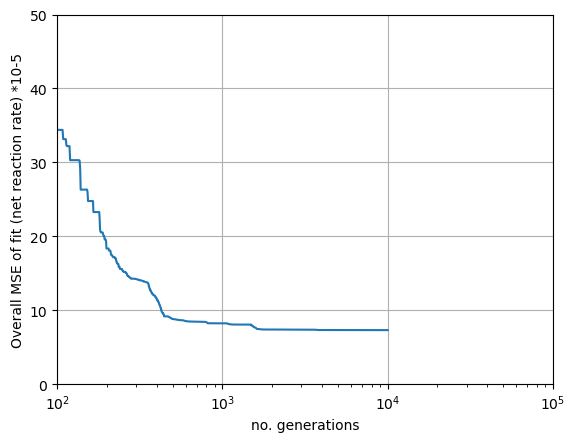

In [32]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [33]:
for i in range(len (res.X)):
    print (res.X[i])

0.16062264093520723
7.66039751510149
7.701423549502914
0.8180830005369603
8.256084496990766
8.242506367031222
8.3150424155757
0.7165252388936907
6.743062554436318
6.78804190997814
6.774383591587585
6.728016320030475
1.2481154196959152
7.309756339758707
7.0465728507199845
7.454035943244249
7.2597240005611585
1.998650614921835
8.019761768745926
1.3068056034052595
8.264822081187537
8.295187670348179
8.347380461532781
7.3443691212118045
2.160144167123839
8.174951271748473
2.4981939850751615
5.512769603527469
7.528306250284408
7.509886955708221
0.880932595721568
7.89108803916653
-1.3010299999999995
0.5222070715435958


In [34]:
res.X

array([ 0.16062264,  7.66039752,  7.70142355,  0.818083  ,  8.2560845 ,
        8.24250637,  8.31504242,  0.71652524,  6.74306255,  6.78804191,
        6.77438359,  6.72801632,  1.24811542,  7.30975634,  7.04657285,
        7.45403594,  7.259724  ,  1.99865061,  8.01976177,  1.3068056 ,
        8.26482208,  8.29518767,  8.34738046,  7.34436912,  2.16014417,
        8.17495127,  2.49819399,  5.5127696 ,  7.52830625,  7.50988696,
        0.8809326 ,  7.89108804, -1.30103   ,  0.52220707])

In [35]:
# Use stored solution
kr = [1e+01, 10**8.5,10**8.5, # AtoB
      1e+02, 10**9, 10**9, 10**9, # HMGS
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # HMGR
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # MK        
      1e+02, 1e+08, # PMK
      1e+01, 1e+08, 1e+08, 1e+08, 1e+07, # PMD
      1e+01, 1e+07, # IDI 
      1e+03, 1e+06, 1e+08, 1e+08, # GPPS
      1e+01, 1e+08, # LS
      10**0.1] # Vin set to 0.05, ks3
    
import numpy as np
logkr=np.log10(kr)
logkr

array([1. , 8.5, 8.5, 2. , 9. , 9. , 9. , 2. , 8. , 8. , 8. , 8. , 2. ,
       8. , 8. , 8. , 8. , 2. , 8. , 1. , 8. , 8. , 8. , 7. , 1. , 7. ,
       3. , 6. , 8. , 8. , 1. , 8. , 0.1])

In [36]:
for i in range(len (logkr)):
    print (logkr[i])

1.0
8.5
8.5
2.0
9.0
9.0
9.0
2.0
8.0
8.0
8.0
8.0
2.0
8.0
8.0
8.0
8.0
2.0
8.0
1.0
8.0
8.0
8.0
7.0
1.0
7.0
3.0
6.0
8.0
8.0
1.0
8.0
0.10000000000000002


In [37]:
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-2]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

1.0: 0.16062264093520723
8.5: 7.66039751510149
8.5: 7.701423549502914
2.0: 0.8180830005369603
9.0: 8.256084496990766
9.0: 8.242506367031222
9.0: 8.3150424155757
2.0: 0.7165252388936907
8.0: 6.743062554436318
8.0: 6.78804190997814
8.0: 6.774383591587585
8.0: 6.728016320030475
2.0: 1.2481154196959152
8.0: 7.309756339758707
8.0: 7.0465728507199845
8.0: 7.454035943244249
8.0: 7.2597240005611585
2.0: 1.998650614921835
8.0: 8.019761768745926
1.0: 1.3068056034052595
8.0: 8.264822081187537
8.0: 8.295187670348179
8.0: 8.347380461532781
7.0: 7.3443691212118045
1.0: 2.160144167123839
7.0: 8.174951271748473
3.0: 2.4981939850751615
6.0: 5.512769603527469
8.0: 7.528306250284408
8.0: 7.509886955708221
1.0: 0.880932595721568
8.0: 7.89108803916653
0.10000000000000002: 0.5222070715435958
coeff fit: 0.9352443018445272
r: 0.9670802975164613
